In [26]:
#Mitchell Schiworski, Jan 2019
#
#Code to insert a new OZHF detector into a network with H1,L1,V1 operating at A+ and
#move the OZHF detector to different locations in Australia.
#Afterwards, a NSNS signal is injected and the network is tested by
#attempting to recover sky localisation data.

import numpy as np
import bilby
import gwinc
import matplotlib.pyplot as plt
import functools
import sys
import io
import cartopy.crs as ccrs
import scipy
import time
from multiprocessing import pool
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull


nprocesses = 2 #number of process to run the sampler with
nsamples = 1000 #number of sample points used in sampler
npoints = 10 #sqrt of number of locations sampling points
verbose = False #if true sampler will print progress
hide_plots = True #if true, will suppress output of all plots other than the 95% cred area plots

In [27]:
def get_95CI_area(sample_array) :
    #gets the 95% credible area from the sample array passed
    Dec = scipy.stats.bayes_mvs(sample_array[:,0],0.95)
    RA = scipy.stats.bayes_mvs(sample_array[:,1],0.95)

    Dec_bounds = Dec[0][1]
    RA_bounds = RA[0][1]

    #-?-calculate sky area from these limits
    area = np.pi*( abs(Dec_bounds[1]-Dec_bounds[0]) * abs(RA_bounds[1]-RA_bounds[0]) )
    return area

def plot_cities(color='black') :
    #---plots capital cities of Aus---
                 #  Adel ,  Perth,   Darw,  Bris ,   Syd , Can   , Melb  #
    city_lats =  [-34.92 , -31.95, -12.46, -27.47, -33.87, -35.28, -37.81]
    city_longs = [ 138.59, 115.85, 130.84, 153.02, 151.21, 149.13, 144.96]
    
    for ii in range(len(city_lats)) :
        plt.plot(city_longs[ii],city_lats[ii],marker='.',color=color,linestyle="")
        
def normalise_vector(vector) :
    #normalises the vector passed to the function, so that all values lie between 0 and 1
    if max(vector) == min(vector) :
        norm_vector = [1 for  i in vector]
    else :
        norm_vector = [( i - min(vector))/( max(vector) - min(vector) ) for i in vector]
    return norm_vector

@contextmanager
def suppress_stdout_stderr(): #suppresses output to terminal
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

def convert_to_coord_matrix(vector) :
    #converts a vector back into a square meshgrid of co-ords.
    n = int(np.sqrt(float(len(vector))))
    if(n**2 != len(vector)) :
        print("!!! Error !!! ... the input vector is not of even length")
        sys.exit()
    Z = [[0] * n for i in range(n)]
    index_count=0
    for ii in range(n):
        for jj in range(n):
            Z[ii][jj] = vector[index_count]
            index_count=index_count+1
    return(Z)

def run_sampler_with_detector_coords(i) :
    #runs the sampler, with a OZHF detector at the given lat/long
    #i is the index of the co-ords chosen from the proposed_latitude & proposed_longitude vectors.


    ifos = existing_ifos
    ifos.append(OZHF_list[i])
    
    priors = bilby.gw.prior.BNSPriorDict()
    for variable in [    'mass_1', 'mass_2', 'chi_1', 'chi_2', 'luminosity_distance',
        'iota', 'psi', 'phase', 'geocent_time', 'lambda_1', 'lambda_2']:
        priors[variable] = injection_parameters[variable]

    #----- inject signal into detectors -----
    for interferometer in ifos:
        interferometer.set_strain_data_from_power_spectral_density(
            sampling_frequency=sampling_frequency, duration=duration,
            start_time=start_time)
        interferometer.inject_signal(parameters=injection_parameters,
                                  waveform_generator=waveform_generator)

    #----- create likelihood -----

    likelihood = bilby.gw.GravitationalWaveTransient(
            interferometers=ifos, waveform_generator=waveform_generator\
            ,time_marginalization=True,phase_marginalization=True,distance_marginalization=False\
            ,priors=priors)


    #----- Run Sampler -----

    
    sampler = 'nestle'
    result = bilby.core.sampler.run_sampler(likelihood=likelihood, priors=priors, outdir='OZHF_locations_with_H1_L1_V1_outdir',sampler=sampler,npoints=nsamples\
                              ,injection_parameters=injection_parameters,verbose=verbose)


    #----- write useful Data to file ----

    output = '%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\n' \
             %(proposed_latitude[i],proposed_longitude[i],result.get_injection_credible_level('ra')\
               ,result.get_injection_credible_level('dec'),result.log_bayes_factor,result.log_evidence\
               ,result.posterior_volume,get_95CI_area(result.samples))
    
    return output


In [28]:
#-------- Create NSNS signal --------
#(code taken from bibly injection example)

injection_parameters = dict(
    mass_1=1.5, mass_2=1.3, chi_1=0.02, chi_2=0.02, luminosity_distance=50.,
    iota=0.4, psi=2.659, phase=1.3, geocent_time=1126259642.413,
    ra=1.375, dec=-1.2108, lambda_1=400, lambda_2=450)


# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 8
sampling_frequency = 2 * 1570.
start_time = injection_parameters['geocent_time'] + 2 - duration

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(waveform_approximant='TaylorF2',
                          reference_frequency=50., minimum_frequency=40.0)

# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments)

In [29]:
#-------- Create prior for BNS ----

# Use delta functions about injected value for all but RA / Dec
priors = bilby.gw.prior.BNSPriorDict()
for variable in [    'mass_1', 'mass_2', 'chi_1', 'chi_2', 'luminosity_distance',
    'iota', 'psi', 'phase', 'geocent_time', 'lambda_1', 'lambda_2']:
    priors[variable] = injection_parameters[variable]



20:55 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]


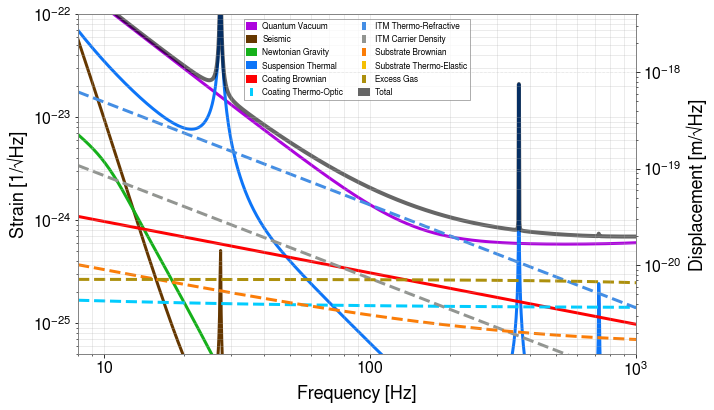

In [30]:
#-------- Create OZHF detector profile --------
detector_min_freq = 8
detector_max_freq = 1000
detector_Xarm_aximuth = 2.0 #-?-same as in bibly documentation example
detector_Yarm_aximuth = 125.0

OZHF_freqs = np.logspace(np.log10(detector_min_freq),np.log10(detector_max_freq),1000)
OZHF_gwinc = gwinc.load_ifo('./ozhf.yaml')

OZHF_gwinc.Infrastructure.Length = 4000
OZHF_gwinc.Optics.Curvature.ETM = OZHF_gwinc.Infrastructure.Length*0.6
OZHF_gwinc.Optics.Curvature.ITM = OZHF_gwinc.Infrastructure.Length*0.6


OZHF_gwinc = gwinc.precompIFO(OZHF_freqs, OZHF_gwinc)
OZHF_gwinc_noises = gwinc.noise_calc(OZHF_freqs, OZHF_gwinc)
OZHF_psd = OZHF_gwinc_noises['Total']

#--plot noise profile--
fig = gwinc.plot_noise(OZHF_gwinc, OZHF_gwinc_noises)
fig.axes[0].set_ylim(5e-26, 1e-22)
fig.set_figwidth(10)
fig.set_figheight(6.25)

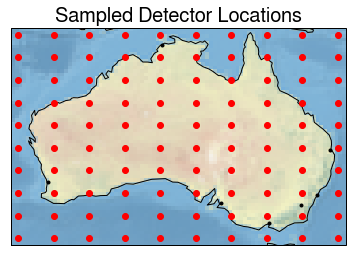

In [31]:
#-------- Create list of lat/longs & plot over map--------

#create meshgrid of lat/long inside a rectangle conatining australia
latitude_limits =  [-40.0,-11.0] #min/max values of lat/long
longitude_limits = [112.0,154.0]
number_of_latitude_points = npoints
number_of_longitude_points = npoints

#create a meshgrid of points within rectangle defined by the limits
mesh_lat, mesh_long = np.meshgrid(np.linspace(latitude_limits[0],latitude_limits[1],number_of_latitude_points),\
                                    np.linspace(longitude_limits[0],longitude_limits[1],number_of_longitude_points))

#flatten 2d co-ord matrices to 1-d vectors containing all combinations of points
proposed_latitude = [y for x in mesh_lat for y in x]
proposed_longitude = [y for x in mesh_long for y in x]


#---- Plot the sampled locations over map of Aus ----
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
plt.plot(proposed_longitude,proposed_latitude,color='red',marker='o',linestyle="")
plt.title("Sampled Detector Locations")
plt.show()



In [32]:
#-------- Create array of proposed detectors --------
newDetector=[]
for i in range(len(proposed_latitude)) :

    OZHF = bilby.gw.detector.Interferometer(power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=OZHF_freqs,psd_array=OZHF_psd)\
                                           ,name='OZHF',length=OZHF_gwinc.Infrastructure.Length, minimum_frequency=detector_min_freq,maximum_frequency=detector_max_freq\
                                           ,latitude=proposed_latitude[i],longitude=proposed_longitude[i],elevation=0\
                                            ,xarm_azimuth=detector_Xarm_aximuth,yarm_azimuth=detector_Yarm_aximuth)
    
    newDetector.append(OZHF)
OZHF_list = bilby.gw.detector.InterferometerList(newDetector)
OZHF_list.set_strain_data_from_power_spectral_densities(
sampling_frequency=sampling_frequency, duration=duration,
start_time=start_time)

/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [33]:
#------ Create and Setup Output file -----
try:
    fp = open('./OZHF_locations_with_H1_L1_V1_outdir/credible_levels.txt',mode='w')
except IOError:
    print('Error opening file, exiting ...')
    sys.exit
    
fp.write('%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\t%-24s\n' \
         %("Latitude","Longitude","RA_Credible","Dec_Credible","Log_Bayes_Factor",\
           "Log_Evidence","Posterior_Volume","95_Cred_Area"))

fp.close()

In [34]:
    frequencies = np.logspace(0, 3, 1000)
    gwinc_detector = gwinc.load_ifo('A+')
    gwinc_detector = gwinc.precompIFO(frequencies, gwinc_detector)
    gwinc_noises = gwinc.noise_calc(frequencies, gwinc_detector)

    Aplus_psd = gwinc_noises['Total']

    existing_ifos = bilby.gw.detector.InterferometerList(['H1','L1','V1'])
    for interferometer in existing_ifos:
        interferometer.power_spectral_density =\
            bilby.gw.detector.PowerSpectralDensity(frequency_array=frequencies, psd_array=Aplus_psd)    
        
    existing_ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=start_time)


    OZHF_list.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=start_time)

/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise


In [35]:
#Run the sampler using multiple processes

def mp_handler() : #define the handler which will handle the output from worker processes and write output to file
    p=pool.Pool(processes=nprocesses)
    
    with open('./OZHF_locations_with_H1_L1_V1_outdir/credible_levels.txt',mode='a') as fp :
        for i,output in enumerate(p.imap(run_sampler_with_detector_coords,range(len(OZHF_list))) ) :
            print("\n\n-------writing output %d-------\n\n" %(i))
            fp.write(output) #!!!!!

if __name__ == '__main__' :
    mp_handler()


20:56 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
20:56 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_dens

20:56 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
20:56 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
20:56 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
20:56 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
20:56 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
20:56 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
20:56 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
20:56 bilby INFO    : No prior given, using default BBH priors

21:13 bilby INFO    : Sampling time: 0:17:43.261578
21:13 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
21:13 bilby INFO    : Summary of results:
nsamples: 18003
log_noise_evidence: -38531.606
log_evidence: -31507.815 +/-  0.123
log_bayes_factor: 7023.791 +/-  0.123

21:13 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 0-------




21:13 bilby INFO    : Injected signal in H1:
21:13 bilby INFO    :   optimal SNR = 63.83
21:13 bilby INFO    :   matched filter SNR = 64.07+0.91j
21:13 bilby INFO    :   mass_1 = 1.5
21:13 bilby INFO    :   mass_2 = 1.3
21:13 bilby INFO    :   chi_1 = 0.02
21:13 bilby INFO    :   chi_2 = 0.02
21:13 bilby INFO    :   luminosity_distance = 50.0
21:13 bilby INFO    :   iota = 0.4
21:13 bilby INFO    :   psi = 2.659
21:13 bilby INFO    :   phase = 1.3
21:13 bilby INFO    :   geocent_time = 1126259642.413
21:13 bilby INFO    :   ra = 1.375
21:13 bilby INFO    :   dec = -1.2108
21:13 bilby INFO    :   lambda_1 = 400
21:13 bilby INFO    :   lambda_2 = 450
21:13 bilby INFO    : Injected signal in L1:
21:13 bilby INFO    :   optimal SNR = 51.70
21:13 bilby INFO    :   matched filter SNR = 52.16+0.35j
21:13 bilby INFO    :   mass_1 = 1.5
21:13 bilby INFO    :   mass_2 = 1.3
21:13 bilby INFO    :   chi_1 = 0.02
21:13 bilby INFO    :   chi_2 = 0.02
21:13 bilby INFO    :   luminosity_distance = 50.

21:14 bilby INFO    : Sampling time: 0:18:22.406593
21:14 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
21:14 bilby INFO    : Summary of results:
nsamples: 18057
log_noise_evidence: -38473.277
log_evidence: -31508.404 +/-  0.123
log_bayes_factor: 6964.874 +/-  0.123

21:14 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 1-------




21:14 bilby INFO    : Injected signal in H1:
21:14 bilby INFO    :   optimal SNR = 63.83
21:14 bilby INFO    :   matched filter SNR = 63.95-0.39j
21:14 bilby INFO    :   mass_1 = 1.5
21:14 bilby INFO    :   mass_2 = 1.3
21:14 bilby INFO    :   chi_1 = 0.02
21:14 bilby INFO    :   chi_2 = 0.02
21:14 bilby INFO    :   luminosity_distance = 50.0
21:14 bilby INFO    :   iota = 0.4
21:14 bilby INFO    :   psi = 2.659
21:14 bilby INFO    :   phase = 1.3
21:14 bilby INFO    :   geocent_time = 1126259642.413
21:14 bilby INFO    :   ra = 1.375
21:14 bilby INFO    :   dec = -1.2108
21:14 bilby INFO    :   lambda_1 = 400
21:14 bilby INFO    :   lambda_2 = 450
21:14 bilby INFO    : Injected signal in L1:
21:14 bilby INFO    :   optimal SNR = 51.70
21:14 bilby INFO    :   matched filter SNR = 52.33+0.05j
21:14 bilby INFO    :   mass_1 = 1.5
21:14 bilby INFO    :   mass_2 = 1.3
21:14 bilby INFO    :   chi_1 = 0.02
21:14 bilby INFO    :   chi_2 = 0.02
21:14 bilby INFO    :   luminosity_distance = 50.

21:33 bilby INFO    : Sampling time: 0:19:38.185108
21:33 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
21:33 bilby INFO    : Summary of results:
nsamples: 18211
log_noise_evidence: -47570.293
log_evidence: -39431.396 +/-  0.124
log_bayes_factor: 8138.897 +/-  0.124

21:33 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 2-------




21:33 bilby INFO    : Injected signal in H1:
21:33 bilby INFO    :   optimal SNR = 63.83
21:33 bilby INFO    :   matched filter SNR = 64.09-0.10j
21:33 bilby INFO    :   mass_1 = 1.5
21:33 bilby INFO    :   mass_2 = 1.3
21:33 bilby INFO    :   chi_1 = 0.02
21:33 bilby INFO    :   chi_2 = 0.02
21:33 bilby INFO    :   luminosity_distance = 50.0
21:33 bilby INFO    :   iota = 0.4
21:33 bilby INFO    :   psi = 2.659
21:33 bilby INFO    :   phase = 1.3
21:33 bilby INFO    :   geocent_time = 1126259642.413
21:33 bilby INFO    :   ra = 1.375
21:33 bilby INFO    :   dec = -1.2108
21:33 bilby INFO    :   lambda_1 = 400
21:33 bilby INFO    :   lambda_2 = 450
21:33 bilby INFO    : Injected signal in L1:
21:33 bilby INFO    :   optimal SNR = 51.70
21:33 bilby INFO    :   matched filter SNR = 52.60+0.08j
21:33 bilby INFO    :   mass_1 = 1.5
21:33 bilby INFO    :   mass_2 = 1.3
21:33 bilby INFO    :   chi_1 = 0.02
21:33 bilby INFO    :   chi_2 = 0.02
21:33 bilby INFO    :   luminosity_distance = 50.

21:34 bilby INFO    : Sampling time: 0:20:13.869421
21:34 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
21:34 bilby INFO    : Summary of results:
nsamples: 18155
log_noise_evidence: -47429.962
log_evidence: -39397.554 +/-  0.124
log_bayes_factor: 8032.409 +/-  0.124

21:34 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 3-------




21:34 bilby INFO    : Injected signal in H1:
21:34 bilby INFO    :   optimal SNR = 63.83
21:34 bilby INFO    :   matched filter SNR = 63.88-1.49j
21:34 bilby INFO    :   mass_1 = 1.5
21:34 bilby INFO    :   mass_2 = 1.3
21:34 bilby INFO    :   chi_1 = 0.02
21:34 bilby INFO    :   chi_2 = 0.02
21:34 bilby INFO    :   luminosity_distance = 50.0
21:34 bilby INFO    :   iota = 0.4
21:34 bilby INFO    :   psi = 2.659
21:34 bilby INFO    :   phase = 1.3
21:34 bilby INFO    :   geocent_time = 1126259642.413
21:34 bilby INFO    :   ra = 1.375
21:34 bilby INFO    :   dec = -1.2108
21:34 bilby INFO    :   lambda_1 = 400
21:34 bilby INFO    :   lambda_2 = 450
21:34 bilby INFO    : Injected signal in L1:
21:34 bilby INFO    :   optimal SNR = 51.70
21:34 bilby INFO    :   matched filter SNR = 52.11-0.24j
21:34 bilby INFO    :   mass_1 = 1.5
21:34 bilby INFO    :   mass_2 = 1.3
21:34 bilby INFO    :   chi_1 = 0.02
21:34 bilby INFO    :   chi_2 = 0.02
21:34 bilby INFO    :   luminosity_distance = 50.

21:56 bilby INFO    : Sampling time: 0:22:45.430736
21:56 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
21:56 bilby INFO    : Summary of results:
nsamples: 18218
log_noise_evidence: -56017.777
log_evidence: -46966.210 +/-  0.124
log_bayes_factor: 9051.567 +/-  0.124

21:56 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 4-------




21:56 bilby INFO    : Injected signal in H1:
21:56 bilby INFO    :   optimal SNR = 63.83
21:56 bilby INFO    :   matched filter SNR = 63.82+0.21j
21:56 bilby INFO    :   mass_1 = 1.5
21:56 bilby INFO    :   mass_2 = 1.3
21:56 bilby INFO    :   chi_1 = 0.02
21:56 bilby INFO    :   chi_2 = 0.02
21:56 bilby INFO    :   luminosity_distance = 50.0
21:56 bilby INFO    :   iota = 0.4
21:56 bilby INFO    :   psi = 2.659
21:56 bilby INFO    :   phase = 1.3
21:56 bilby INFO    :   geocent_time = 1126259642.413
21:56 bilby INFO    :   ra = 1.375
21:56 bilby INFO    :   dec = -1.2108
21:56 bilby INFO    :   lambda_1 = 400
21:56 bilby INFO    :   lambda_2 = 450
21:56 bilby INFO    : Injected signal in L1:
21:56 bilby INFO    :   optimal SNR = 51.70
21:56 bilby INFO    :   matched filter SNR = 51.58+0.16j
21:56 bilby INFO    :   mass_1 = 1.5
21:56 bilby INFO    :   mass_2 = 1.3
21:56 bilby INFO    :   chi_1 = 0.02
21:56 bilby INFO    :   chi_2 = 0.02
21:56 bilby INFO    :   luminosity_distance = 50.

21:57 bilby INFO    : Sampling time: 0:22:12.184029
21:57 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
21:57 bilby INFO    : Summary of results:
nsamples: 18219
log_noise_evidence: -55971.002
log_evidence: -47217.678 +/-  0.124
log_bayes_factor: 8753.324 +/-  0.124

21:57 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 5-------




21:57 bilby INFO    : Injected signal in H1:
21:57 bilby INFO    :   optimal SNR = 63.83
21:57 bilby INFO    :   matched filter SNR = 63.42-0.29j
21:57 bilby INFO    :   mass_1 = 1.5
21:57 bilby INFO    :   mass_2 = 1.3
21:57 bilby INFO    :   chi_1 = 0.02
21:57 bilby INFO    :   chi_2 = 0.02
21:57 bilby INFO    :   luminosity_distance = 50.0
21:57 bilby INFO    :   iota = 0.4
21:57 bilby INFO    :   psi = 2.659
21:57 bilby INFO    :   phase = 1.3
21:57 bilby INFO    :   geocent_time = 1126259642.413
21:57 bilby INFO    :   ra = 1.375
21:57 bilby INFO    :   dec = -1.2108
21:57 bilby INFO    :   lambda_1 = 400
21:57 bilby INFO    :   lambda_2 = 450
21:57 bilby INFO    : Injected signal in L1:
21:57 bilby INFO    :   optimal SNR = 51.70
21:57 bilby INFO    :   matched filter SNR = 51.99-0.26j
21:57 bilby INFO    :   mass_1 = 1.5
21:57 bilby INFO    :   mass_2 = 1.3
21:57 bilby INFO    :   chi_1 = 0.02
21:57 bilby INFO    :   chi_2 = 0.02
21:57 bilby INFO    :   luminosity_distance = 50.

22:24 bilby INFO    : Sampling time: 0:27:35.973724
22:24 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
22:24 bilby INFO    : Summary of results:
nsamples: 18496
log_noise_evidence: -65147.792
log_evidence: -55149.249 +/-  0.125
log_bayes_factor: 9998.543 +/-  0.125

22:24 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 6-------




22:24 bilby INFO    : Injected signal in H1:
22:24 bilby INFO    :   optimal SNR = 63.83
22:24 bilby INFO    :   matched filter SNR = 62.84+0.94j
22:24 bilby INFO    :   mass_1 = 1.5
22:24 bilby INFO    :   mass_2 = 1.3
22:24 bilby INFO    :   chi_1 = 0.02
22:24 bilby INFO    :   chi_2 = 0.02
22:24 bilby INFO    :   luminosity_distance = 50.0
22:24 bilby INFO    :   iota = 0.4
22:24 bilby INFO    :   psi = 2.659
22:24 bilby INFO    :   phase = 1.3
22:24 bilby INFO    :   geocent_time = 1126259642.413
22:24 bilby INFO    :   ra = 1.375
22:24 bilby INFO    :   dec = -1.2108
22:24 bilby INFO    :   lambda_1 = 400
22:24 bilby INFO    :   lambda_2 = 450
22:24 bilby INFO    : Injected signal in L1:
22:24 bilby INFO    :   optimal SNR = 51.70
22:24 bilby INFO    :   mass_1 = 1.5
22:24 bilby INFO    :   matched filter SNR = 51.87+0.37j
22:24 bilby INFO    :   mass_2 = 1.3
22:24 bilby INFO    :   chi_1 = 0.02
22:24 bilby INFO    :   chi_2 = 0.02
22:24 bilby INFO    :   luminosity_distance = 50.

22:24 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:24 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:24 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:24 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:24 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:24 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:24 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:24 bilby INFO    : No prior given, using default BBH priors



-------writing output 7-------




22:24 bilby INFO    : Injected signal in H1:
22:24 bilby INFO    :   optimal SNR = 63.83
22:24 bilby INFO    :   matched filter SNR = 63.79-0.07j
22:24 bilby INFO    :   mass_1 = 1.5
22:24 bilby INFO    :   mass_2 = 1.3
22:24 bilby INFO    :   chi_1 = 0.02
22:24 bilby INFO    :   chi_2 = 0.02
22:24 bilby INFO    :   luminosity_distance = 50.0
22:24 bilby INFO    :   iota = 0.4
22:24 bilby INFO    :   psi = 2.659
22:24 bilby INFO    :   phase = 1.3
22:24 bilby INFO    :   geocent_time = 1126259642.413
22:24 bilby INFO    :   ra = 1.375
22:24 bilby INFO    :   dec = -1.2108
22:24 bilby INFO    :   lambda_1 = 400
22:24 bilby INFO    :   lambda_2 = 450
22:24 bilby INFO    : Injected signal in L1:
22:24 bilby INFO    :   optimal SNR = 51.70
22:24 bilby INFO    :   matched filter SNR = 52.24+0.68j
22:24 bilby INFO    :   mass_1 = 1.5
22:24 bilby INFO    :   mass_2 = 1.3
22:24 bilby INFO    :   chi_1 = 0.02
22:24 bilby INFO    :   chi_2 = 0.02
22:24 bilby INFO    :   luminosity_distance = 50.

22:24 bilby INFO    : Using sampler Nestle with kwargs {'verbose': False, 'method': 'multi', 'npoints': 1000, 'update_interval': None, 'npdim': None, 'maxiter': None, 'maxcall': None, 'dlogz': None, 'decline_factor': None, 'rstate': None, 'callback': None}


22:54 bilby INFO    : Sampling time: 0:29:30.232795
22:54 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
22:54 bilby INFO    : Summary of results:
nsamples: 18548
log_noise_evidence: -73592.798
log_evidence: -62974.188 +/-  0.125
log_bayes_factor: 10618.610 +/-  0.125

22:54 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
22:54 bilby INFO    : Injected signal in H1:
22:54 bilby INFO    :   optimal SNR = 63.83
22:54 bilby INFO    :   matched filter SNR = 64.39+0.07j
22:54 bilby INFO    :   mass_1 = 1.5
22:54 bilby INFO    :   mass_2 = 1.3
22:54 bilby INFO    :   chi_1 = 0.02
22:54 bilby INFO    :   chi_2 = 0.02
22:54 bilby INFO    :   luminosity_distance = 50.0
22:54 bilby INFO    :   iota = 0.4
22:54 bilby INFO    :   psi = 2.659
22:54 bilby INFO    :   phase = 1.3
22:54 bilby INFO    :   geocent_time = 1126259642.413
22:54 bilby INFO    :   ra = 1.375
22:54 bilby INFO    :   dec = 

22:54 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:54 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
22:54 bilby INFO    : Search parameters:
22:54 bilby INFO    :   dec = Cosine(name='dec', latex_label='$\\mathrm{DEC}$', unit=None, minimum=-1.5707963267948966, maximum=1.5707963267948966)
22:54 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None)
22:54 bilby INFO    :   mass_1 = 1.5
22:54 bilby INFO    :   mass_2 = 1.3
22:54 bilby INFO    :   chi_1 = 0.02
22:54 bilby INFO    :   chi_2 = 0.02
22:54 bilby INFO    :   luminosity_distance = 50.0
22:54 bilby INFO    :   iota = 0.4
22:54 bilby INFO    :   psi = 2.659
22:54 bilby INFO    :   phase = 0.0
22:54 bilby INFO    :   lambda_1 = 400
22:54 bilby INFO    :   lambda_2 = 450
22:54 bilby INFO    :   geocent_

22:55 bilby INFO    : Sampling time: 0:30:47.933068
22:55 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
22:55 bilby INFO    : Summary of results:
nsamples: 18618
log_noise_evidence: -73777.453
log_evidence: -63082.726 +/-  0.126
log_bayes_factor: 10694.727 +/-  0.126

22:55 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 8-------




-------writing output 9-------




22:55 bilby INFO    : Injected signal in H1:
22:55 bilby INFO    :   optimal SNR = 63.83
22:55 bilby INFO    :   matched filter SNR = 63.81+0.41j
22:55 bilby INFO    :   mass_1 = 1.5
22:55 bilby INFO    :   mass_2 = 1.3
22:55 bilby INFO    :   chi_1 = 0.02
22:55 bilby INFO    :   chi_2 = 0.02
22:55 bilby INFO    :   luminosity_distance = 50.0
22:55 bilby INFO    :   iota = 0.4
22:55 bilby INFO    :   psi = 2.659
22:55 bilby INFO    :   phase = 1.3
22:55 bilby INFO    :   geocent_time = 1126259642.413
22:55 bilby INFO    :   ra = 1.375
22:55 bilby INFO    :   dec = -1.2108
22:55 bilby INFO    :   lambda_1 = 400
22:55 bilby INFO    :   lambda_2 = 450
22:55 bilby INFO    : Injected signal in L1:
22:55 bilby INFO    :   optimal SNR = 51.70
22:55 bilby INFO    :   matched filter SNR = 51.37+0.09j
22:55 bilby INFO    :   mass_1 = 1.5
22:55 bilby INFO    :   mass_2 = 1.3
22:55 bilby INFO    :   chi_1 = 0.02
22:55 bilby INFO    :   chi_2 = 0.02
22:55 bilby INFO    :   luminosity_distance = 50.

22:55 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None)
22:55 bilby INFO    :   mass_1 = 1.5
22:55 bilby INFO    :   mass_2 = 1.3
22:55 bilby INFO    :   chi_1 = 0.02
22:55 bilby INFO    :   chi_2 = 0.02
22:55 bilby INFO    :   luminosity_distance = 50.0
22:55 bilby INFO    :   iota = 0.4
22:55 bilby INFO    :   psi = 2.659
22:55 bilby INFO    :   phase = 0.0
22:55 bilby INFO    :   lambda_1 = 400
22:55 bilby INFO    :   lambda_2 = 450
22:55 bilby INFO    :   geocent_time = 1126259636.413
22:55 bilby INFO    : Single likelihood evaluation took 1.119e-01 s
22:55 bilby INFO    : Using sampler Nestle with kwargs {'verbose': False, 'method': 'multi', 'npoints': 1000, 'update_interval': None, 'npdim': None, 'maxiter': None, 'maxcall': None, 'dlogz': None, 'decline_factor': None, 'rstate': None, 'callback': None}


23:28 bilby INFO    : Sampling time: 0:34:42.578601
23:28 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
23:28 bilby INFO    : Summary of results:
nsamples: 18571
log_noise_evidence: -83120.738
log_evidence: -71129.409 +/-  0.125
log_bayes_factor: 11991.329 +/-  0.125

23:28 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 10-------




23:28 bilby INFO    : Injected signal in H1:
23:28 bilby INFO    :   optimal SNR = 63.83
23:28 bilby INFO    :   matched filter SNR = 64.87-0.22j
23:28 bilby INFO    :   mass_1 = 1.5
23:28 bilby INFO    :   mass_2 = 1.3
23:28 bilby INFO    :   chi_1 = 0.02
23:28 bilby INFO    :   chi_2 = 0.02
23:28 bilby INFO    :   luminosity_distance = 50.0
23:28 bilby INFO    :   iota = 0.4
23:28 bilby INFO    :   psi = 2.659
23:28 bilby INFO    :   phase = 1.3
23:28 bilby INFO    :   geocent_time = 1126259642.413
23:28 bilby INFO    :   ra = 1.375
23:28 bilby INFO    :   dec = -1.2108
23:28 bilby INFO    :   lambda_1 = 400
23:28 bilby INFO    :   lambda_2 = 450
23:28 bilby INFO    : Injected signal in L1:
23:28 bilby INFO    :   optimal SNR = 51.70
23:28 bilby INFO    :   matched filter SNR = 51.26-0.14j
23:28 bilby INFO    :   mass_1 = 1.5
23:28 bilby INFO    :   mass_2 = 1.3
23:28 bilby INFO    :   chi_1 = 0.02
23:28 bilby INFO    :   chi_2 = 0.02
23:28 bilby INFO    :   luminosity_distance = 50.

23:28 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
23:28 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
23:28 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
23:28 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
23:28 bilby INFO    : Search parameters:
23:28 bilby INFO    :   dec = Cosine(name='dec', latex_label='$\\mathrm{DEC}$', unit=None, minimum=-1.5707963267948966, maximum=1.5707963267948966)
23:28 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None)
23:28 bilby INFO    :   mass_1 = 1.5
23:28 bilby INFO    :   mass_2 = 1.3
23:28 bilby INFO    :   chi_1 = 0.02
23:28 bilby INFO    :   chi_2 = 0.02


23:29 bilby INFO    : Sampling time: 0:34:10.828906
23:29 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
23:29 bilby INFO    : Summary of results:
nsamples: 18629
log_noise_evidence: -83416.194
log_evidence: -71081.020 +/-  0.126
log_bayes_factor: 12335.174 +/-  0.126

23:29 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 11-------




23:29 bilby INFO    : Injected signal in H1:
23:29 bilby INFO    :   optimal SNR = 63.83
23:29 bilby INFO    :   matched filter SNR = 63.96-0.09j
23:29 bilby INFO    :   mass_1 = 1.5
23:29 bilby INFO    :   mass_2 = 1.3
23:29 bilby INFO    :   chi_1 = 0.02
23:29 bilby INFO    :   chi_2 = 0.02
23:29 bilby INFO    :   luminosity_distance = 50.0
23:29 bilby INFO    :   iota = 0.4
23:29 bilby INFO    :   psi = 2.659
23:29 bilby INFO    :   phase = 1.3
23:29 bilby INFO    :   geocent_time = 1126259642.413
23:29 bilby INFO    :   ra = 1.375
23:29 bilby INFO    :   dec = -1.2108
23:29 bilby INFO    :   lambda_1 = 400
23:29 bilby INFO    :   lambda_2 = 450
23:29 bilby INFO    : Injected signal in L1:
23:29 bilby INFO    :   optimal SNR = 51.70
23:29 bilby INFO    :   matched filter SNR = 51.51+0.58j
23:29 bilby INFO    :   mass_1 = 1.5
23:29 bilby INFO    :   mass_2 = 1.3
23:29 bilby INFO    :   chi_1 = 0.02
23:29 bilby INFO    :   chi_2 = 0.02
23:29 bilby INFO    :   luminosity_distance = 50.

23:29 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
23:29 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
23:29 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
23:29 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
23:29 bilby INFO    : Search parameters:
23:29 bilby INFO    :   dec = Cosine(name='dec', latex_label='$\\mathrm{DEC}$', unit=None, minimum=-1.5707963267948966, maximum=1.5707963267948966)
23:29 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None)
23:29 bilby INFO    :   mass_1 = 1.5
23:29 bilby INFO    :   mass_2 = 1.3
23:29 bilby INFO    :   chi_1 = 0.02
23:29 bilby INFO    :   chi_2 = 0.02


00:06 bilby INFO    : Sampling time: 0:37:12.618564
00:06 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
00:06 bilby INFO    : Summary of results:
nsamples: 18395
log_noise_evidence: -92742.063
log_evidence: -79533.614 +/-  0.125
log_bayes_factor: 13208.449 +/-  0.125

00:06 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
00:06 bilby INFO    : Injected signal in H1:
00:06 bilby INFO    :   optimal SNR = 63.83
00:06 bilby INFO    :   matched filter SNR = 64.35-0.68j
00:06 bilby INFO    :   mass_1 = 1.5
00:06 bilby INFO    :   mass_2 = 1.3
00:06 bilby INFO    :   chi_1 = 0.02
00:06 bilby INFO    :   chi_2 = 0.02
00:06 bilby INFO    :   luminosity_distance = 50.0
00:06 bilby INFO    :   iota = 0.4
00:06 bilby INFO    :   psi = 2.659
00:06 bilby INFO    :   phase = 1.3
00:06 bilby INFO    :   geocent_time = 1126259642.413
00:06 bilby INFO    :   ra = 1.375
00:06 bilby INFO    :   dec = 

00:06 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:06 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:06 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:06 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:06 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:06 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:06 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:06 bilby INFO    : No prior given, using default BBH priors



-------writing output 12-------




-------writing output 13-------




00:06 bilby INFO    : Injected signal in H1:
00:06 bilby INFO    :   optimal SNR = 63.83
00:06 bilby INFO    :   matched filter SNR = 63.90+0.25j
00:06 bilby INFO    :   mass_1 = 1.5
00:06 bilby INFO    :   mass_2 = 1.3
00:06 bilby INFO    :   chi_1 = 0.02
00:06 bilby INFO    :   chi_2 = 0.02
00:06 bilby INFO    :   luminosity_distance = 50.0
00:06 bilby INFO    :   iota = 0.4
00:06 bilby INFO    :   psi = 2.659
00:06 bilby INFO    :   phase = 1.3
00:06 bilby INFO    :   geocent_time = 1126259642.413
00:06 bilby INFO    :   ra = 1.375
00:06 bilby INFO    :   dec = -1.2108
00:06 bilby INFO    :   lambda_1 = 400
00:06 bilby INFO    :   lambda_2 = 450
00:06 bilby INFO    : Injected signal in L1:
00:06 bilby INFO    :   optimal SNR = 51.70
00:06 bilby INFO    :   matched filter SNR = 52.53-0.17j
00:06 bilby INFO    :   mass_1 = 1.5
00:06 bilby INFO    :   mass_2 = 1.3
00:06 bilby INFO    :   chi_1 = 0.02
00:06 bilby INFO    :   chi_2 = 0.02
00:06 bilby INFO    :   luminosity_distance = 50.

00:07 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:07 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:07 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:07 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:07 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:07 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:07 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:07 bilby INFO    : No prior given, using default BBH priors

00:45 bilby INFO    : Sampling time: 0:38:17.202873
00:45 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
00:45 bilby INFO    : Summary of results:
nsamples: 18588
log_noise_evidence: -100828.716
log_evidence: -86263.763 +/-  0.125
log_bayes_factor: 14564.953 +/-  0.125

00:45 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 14-------




00:45 bilby INFO    : Injected signal in H1:
00:45 bilby INFO    :   optimal SNR = 63.83
00:45 bilby INFO    :   matched filter SNR = 63.50-0.42j
00:45 bilby INFO    :   mass_1 = 1.5
00:45 bilby INFO    :   mass_2 = 1.3
00:45 bilby INFO    :   chi_1 = 0.02
00:45 bilby INFO    :   chi_2 = 0.02
00:45 bilby INFO    :   luminosity_distance = 50.0
00:45 bilby INFO    :   iota = 0.4
00:45 bilby INFO    :   psi = 2.659
00:45 bilby INFO    :   phase = 1.3
00:45 bilby INFO    :   geocent_time = 1126259642.413
00:45 bilby INFO    :   ra = 1.375
00:45 bilby INFO    :   dec = -1.2108
00:45 bilby INFO    :   lambda_1 = 400
00:45 bilby INFO    :   lambda_2 = 450
00:45 bilby INFO    : Injected signal in L1:
00:45 bilby INFO    :   optimal SNR = 51.70
00:45 bilby INFO    :   matched filter SNR = 51.02+0.21j
00:45 bilby INFO    :   mass_1 = 1.5
00:45 bilby INFO    :   mass_2 = 1.3
00:45 bilby INFO    :   chi_1 = 0.02
00:45 bilby INFO    :   chi_2 = 0.02
00:45 bilby INFO    :   luminosity_distance = 50.

00:45 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:45 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:45 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:45 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:45 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:45 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:45 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:45 bilby INFO    : No prior given, using default BBH priors

00:46 bilby INFO    : Sampling time: 0:39:28.821965
00:46 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
00:46 bilby INFO    : Summary of results:
nsamples: 18524
log_noise_evidence: -100688.702
log_evidence: -86473.618 +/-  0.125
log_bayes_factor: 14215.084 +/-  0.125

00:46 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 15-------




00:46 bilby INFO    : Injected signal in H1:
00:46 bilby INFO    :   optimal SNR = 63.83
00:46 bilby INFO    :   matched filter SNR = 64.07-0.49j
00:46 bilby INFO    :   mass_1 = 1.5
00:46 bilby INFO    :   mass_2 = 1.3
00:46 bilby INFO    :   chi_1 = 0.02
00:46 bilby INFO    :   chi_2 = 0.02
00:46 bilby INFO    :   luminosity_distance = 50.0
00:46 bilby INFO    :   iota = 0.4
00:46 bilby INFO    :   psi = 2.659
00:46 bilby INFO    :   phase = 1.3
00:46 bilby INFO    :   geocent_time = 1126259642.413
00:46 bilby INFO    :   ra = 1.375
00:46 bilby INFO    :   dec = -1.2108
00:46 bilby INFO    :   lambda_1 = 400
00:46 bilby INFO    :   lambda_2 = 450
00:46 bilby INFO    : Injected signal in L1:
00:46 bilby INFO    :   optimal SNR = 51.70
00:46 bilby INFO    :   matched filter SNR = 51.35-0.35j
00:46 bilby INFO    :   mass_1 = 1.5
00:46 bilby INFO    :   mass_2 = 1.3
00:46 bilby INFO    :   chi_1 = 0.02
00:46 bilby INFO    :   chi_2 = 0.02
00:46 bilby INFO    :   luminosity_distance = 50.

00:46 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:46 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:46 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:46 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:46 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:46 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:46 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
00:46 bilby INFO    : No prior given, using default BBH priors

01:31 bilby INFO    : Sampling time: 0:44:27.772678
01:31 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
01:31 bilby INFO    : Summary of results:
nsamples: 18696
log_noise_evidence: -109964.723
log_evidence: -94630.365 +/-  0.126
log_bayes_factor: 15334.358 +/-  0.126

01:31 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
01:31 bilby INFO    : Injected signal in H1:
01:31 bilby INFO    :   optimal SNR = 63.83
01:31 bilby INFO    :   matched filter SNR = 64.67-0.05j
01:31 bilby INFO    :   mass_1 = 1.5
01:31 bilby INFO    :   mass_2 = 1.3
01:31 bilby INFO    :   chi_1 = 0.02
01:31 bilby INFO    :   chi_2 = 0.02
01:31 bilby INFO    :   luminosity_distance = 50.0
01:31 bilby INFO    :   iota = 0.4
01:31 bilby INFO    :   psi = 2.659
01:31 bilby INFO    :   phase = 1.3
01:31 bilby INFO    :   geocent_time = 1126259642.413
01:31 bilby INFO    :   ra = 1.375
01:31 bilby INFO    :   dec =

01:31 bilby INFO    :   dec = -1.2108
01:31 bilby INFO    :   lambda_1 = 400
01:31 bilby INFO    :   lambda_2 = 450
01:31 bilby INFO    : Injected signal in OZHF:
01:31 bilby INFO    :   optimal SNR = 45.18
01:31 bilby INFO    :   matched filter SNR = 44.84+0.38j
01:31 bilby INFO    :   mass_1 = 1.5
01:31 bilby INFO    :   mass_2 = 1.3
01:31 bilby INFO    :   chi_1 = 0.02
01:31 bilby INFO    :   chi_2 = 0.02
01:31 bilby INFO    :   luminosity_distance = 50.0
01:31 bilby INFO    :   iota = 0.4
01:31 bilby INFO    :   psi = 2.659
01:31 bilby INFO    :   phase = 1.3
01:31 bilby INFO    :   geocent_time = 1126259642.413
01:31 bilby INFO    :   ra = 1.375
01:31 bilby INFO    :   dec = -1.2108
01:31 bilby INFO    :   lambda_1 = 400
01:31 bilby INFO    :   lambda_2 = 450
01:31 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
01:31 bilby WARNING : Prior not provided for geocent_time, using the BBH default.
01:31 b

01:31 bilby INFO    : Sampling time: 0:46:24.229955
01:31 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
01:31 bilby INFO    : Summary of results:
nsamples: 18734
log_noise_evidence: -110762.509
log_evidence: -95533.175 +/-  0.126
log_bayes_factor: 15229.334 +/-  0.126

01:31 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 16-------




-------writing output 17-------




01:31 bilby INFO    : Injected signal in H1:
01:31 bilby INFO    :   optimal SNR = 63.83
01:31 bilby INFO    :   matched filter SNR = 63.02+0.34j
01:31 bilby INFO    :   mass_1 = 1.5
01:31 bilby INFO    :   mass_2 = 1.3
01:31 bilby INFO    :   chi_1 = 0.02
01:31 bilby INFO    :   chi_2 = 0.02
01:31 bilby INFO    :   luminosity_distance = 50.0
01:31 bilby INFO    :   iota = 0.4
01:31 bilby INFO    :   psi = 2.659
01:31 bilby INFO    :   phase = 1.3
01:31 bilby INFO    :   geocent_time = 1126259642.413
01:31 bilby INFO    :   ra = 1.375
01:31 bilby INFO    :   dec = -1.2108
01:31 bilby INFO    :   lambda_1 = 400
01:31 bilby INFO    :   lambda_2 = 450
01:31 bilby INFO    : Injected signal in L1:
01:31 bilby INFO    :   optimal SNR = 51.70
01:31 bilby INFO    :   matched filter SNR = 51.77+0.61j
01:31 bilby INFO    :   mass_1 = 1.5
01:31 bilby INFO    :   mass_2 = 1.3
01:31 bilby INFO    :   chi_1 = 0.02
01:31 bilby INFO    :   chi_2 = 0.02
01:31 bilby INFO    :   luminosity_distance = 50.

01:31 bilby INFO    :   luminosity_distance = 50.0
01:31 bilby INFO    :   iota = 0.4
01:31 bilby INFO    :   psi = 2.659
01:31 bilby INFO    :   phase = 1.3
01:31 bilby INFO    :   geocent_time = 1126259642.413
01:31 bilby INFO    :   ra = 1.375
01:31 bilby INFO    :   dec = -1.2108
01:31 bilby INFO    :   lambda_1 = 400
01:31 bilby INFO    :   lambda_2 = 450
01:31 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
01:31 bilby WARNING : Prior not provided for geocent_time, using the BBH default.
01:31 bilby WARNING : Prior not provided for phase, using the BBH default.
01:31 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
01:31 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
01:31 bilby INFO    : No prior given, using default BBH priors in /home/mitc

02:18 bilby INFO    : Sampling time: 0:47:25.252158
02:18 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
02:18 bilby INFO    : Summary of results:
nsamples: 18499
log_noise_evidence: -118920.601
log_evidence: -102668.122 +/-  0.125
log_bayes_factor: 16252.479 +/-  0.125

02:18 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 18-------




02:18 bilby INFO    : Injected signal in H1:
02:18 bilby INFO    :   optimal SNR = 63.83
02:18 bilby INFO    :   matched filter SNR = 63.37-0.26j
02:18 bilby INFO    :   mass_1 = 1.5
02:18 bilby INFO    :   mass_2 = 1.3
02:18 bilby INFO    :   chi_1 = 0.02
02:18 bilby INFO    :   chi_2 = 0.02
02:18 bilby INFO    :   luminosity_distance = 50.0
02:18 bilby INFO    :   iota = 0.4
02:18 bilby INFO    :   psi = 2.659
02:18 bilby INFO    :   phase = 1.3
02:18 bilby INFO    :   geocent_time = 1126259642.413
02:18 bilby INFO    :   ra = 1.375
02:18 bilby INFO    :   dec = -1.2108
02:18 bilby INFO    :   lambda_1 = 400
02:18 bilby INFO    :   lambda_2 = 450
02:18 bilby INFO    : Injected signal in L1:
02:18 bilby INFO    :   optimal SNR = 51.70
02:18 bilby INFO    :   matched filter SNR = 51.85+0.13j
02:18 bilby INFO    :   mass_1 = 1.5
02:18 bilby INFO    :   mass_2 = 1.3
02:18 bilby INFO    :   chi_1 = 0.02
02:18 bilby INFO    :   chi_2 = 0.02
02:18 bilby INFO    :   luminosity_distance = 50.

02:18 bilby INFO    :   luminosity_distance = 50.0
02:18 bilby INFO    :   iota = 0.4
02:18 bilby INFO    :   psi = 2.659
02:18 bilby INFO    :   phase = 1.3
02:18 bilby INFO    :   geocent_time = 1126259642.413
02:18 bilby INFO    :   ra = 1.375
02:18 bilby INFO    :   dec = -1.2108
02:18 bilby INFO    :   lambda_1 = 400
02:18 bilby INFO    :   lambda_2 = 450
02:18 bilby INFO    : Injected signal in OZHF:
02:18 bilby INFO    :   optimal SNR = 55.10
02:18 bilby INFO    :   matched filter SNR = 54.90+0.99j
02:18 bilby INFO    :   mass_1 = 1.5
02:18 bilby INFO    :   mass_2 = 1.3
02:18 bilby INFO    :   chi_1 = 0.02
02:18 bilby INFO    :   chi_2 = 0.02
02:18 bilby INFO    :   luminosity_distance = 50.0
02:18 bilby INFO    :   iota = 0.4
02:18 bilby INFO    :   psi = 2.659
02:18 bilby INFO    :   phase = 1.3
02:18 bilby INFO    :   geocent_time = 1126259642.413
02:18 bilby INFO    :   ra = 1.375
02:18 bilby INFO    :   dec = -1.2108
02:18 bilby INFO    :   lambda_1 = 400
02:18 bilby INFO 

02:19 bilby INFO    : Sampling time: 0:47:30.781525
02:19 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
02:19 bilby INFO    : Summary of results:
nsamples: 18602
log_noise_evidence: -118854.495
log_evidence: -102789.067 +/-  0.125
log_bayes_factor: 16065.428 +/-  0.125

02:19 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 19-------




02:19 bilby INFO    : Injected signal in H1:
02:19 bilby INFO    :   optimal SNR = 63.83
02:19 bilby INFO    :   matched filter SNR = 64.25+0.96j
02:19 bilby INFO    :   mass_1 = 1.5
02:19 bilby INFO    :   mass_2 = 1.3
02:19 bilby INFO    :   chi_1 = 0.02
02:19 bilby INFO    :   chi_2 = 0.02
02:19 bilby INFO    :   luminosity_distance = 50.0
02:19 bilby INFO    :   iota = 0.4
02:19 bilby INFO    :   psi = 2.659
02:19 bilby INFO    :   phase = 1.3
02:19 bilby INFO    :   geocent_time = 1126259642.413
02:19 bilby INFO    :   ra = 1.375
02:19 bilby INFO    :   dec = -1.2108
02:19 bilby INFO    :   lambda_1 = 400
02:19 bilby INFO    :   lambda_2 = 450
02:19 bilby INFO    : Injected signal in L1:
02:19 bilby INFO    :   optimal SNR = 51.70
02:19 bilby INFO    :   matched filter SNR = 51.67-0.31j
02:19 bilby INFO    :   mass_1 = 1.5
02:19 bilby INFO    :   mass_2 = 1.3
02:19 bilby INFO    :   chi_1 = 0.02
02:19 bilby INFO    :   chi_2 = 0.02
02:19 bilby INFO    :   luminosity_distance = 50.

02:19 bilby INFO    :   luminosity_distance = 50.0
02:19 bilby INFO    :   iota = 0.4
02:19 bilby INFO    :   psi = 2.659
02:19 bilby INFO    :   phase = 1.3
02:19 bilby INFO    :   geocent_time = 1126259642.413
02:19 bilby INFO    :   ra = 1.375
02:19 bilby INFO    :   dec = -1.2108
02:19 bilby INFO    :   lambda_1 = 400
02:19 bilby INFO    :   lambda_2 = 450
02:19 bilby INFO    : Injected signal in OZHF:
02:19 bilby INFO    :   optimal SNR = 52.49
02:19 bilby INFO    :   matched filter SNR = 53.80-0.78j
02:19 bilby INFO    :   mass_1 = 1.5
02:19 bilby INFO    :   mass_2 = 1.3
02:19 bilby INFO    :   chi_1 = 0.02
02:19 bilby INFO    :   chi_2 = 0.02
02:19 bilby INFO    :   luminosity_distance = 50.0
02:19 bilby INFO    :   iota = 0.4
02:19 bilby INFO    :   psi = 2.659
02:19 bilby INFO    :   phase = 1.3
02:19 bilby INFO    :   geocent_time = 1126259642.413
02:19 bilby INFO    :   ra = 1.375
02:19 bilby INFO    :   dec = -1.2108
02:19 bilby INFO    :   lambda_1 = 400
02:19 bilby INFO 

03:07 bilby INFO    : Sampling time: 0:48:35.114707
03:07 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
03:07 bilby INFO    : Summary of results:
nsamples: 18564
log_noise_evidence: -127562.887
log_evidence: -110192.579 +/-  0.125
log_bayes_factor: 17370.308 +/-  0.125

03:07 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 20-------




03:07 bilby INFO    : Injected signal in H1:
03:07 bilby INFO    :   optimal SNR = 63.83
03:07 bilby INFO    :   matched filter SNR = 63.86-0.44j
03:07 bilby INFO    :   mass_1 = 1.5
03:07 bilby INFO    :   mass_2 = 1.3
03:07 bilby INFO    :   chi_1 = 0.02
03:07 bilby INFO    :   chi_2 = 0.02
03:07 bilby INFO    :   luminosity_distance = 50.0
03:07 bilby INFO    :   iota = 0.4
03:07 bilby INFO    :   psi = 2.659
03:07 bilby INFO    :   phase = 1.3
03:07 bilby INFO    :   geocent_time = 1126259642.413
03:07 bilby INFO    :   ra = 1.375
03:07 bilby INFO    :   dec = -1.2108
03:07 bilby INFO    :   lambda_1 = 400
03:07 bilby INFO    :   lambda_2 = 450
03:07 bilby INFO    : Injected signal in L1:
03:07 bilby INFO    :   optimal SNR = 51.70
03:07 bilby INFO    :   matched filter SNR = 52.20+0.47j
03:07 bilby INFO    :   mass_1 = 1.5
03:07 bilby INFO    :   mass_2 = 1.3
03:07 bilby INFO    :   chi_1 = 0.02
03:07 bilby INFO    :   chi_2 = 0.02
03:07 bilby INFO    :   luminosity_distance = 50.

03:07 bilby INFO    :   luminosity_distance = 50.0
03:07 bilby INFO    :   iota = 0.4
03:07 bilby INFO    :   psi = 2.659
03:07 bilby INFO    :   phase = 1.3
03:07 bilby INFO    :   geocent_time = 1126259642.413
03:07 bilby INFO    :   ra = 1.375
03:07 bilby INFO    :   dec = -1.2108
03:07 bilby INFO    :   lambda_1 = 400
03:07 bilby INFO    :   lambda_2 = 450
03:07 bilby INFO    : Injected signal in OZHF:
03:07 bilby INFO    :   optimal SNR = 55.10
03:07 bilby INFO    :   matched filter SNR = 55.08-1.26j
03:07 bilby INFO    :   mass_1 = 1.5
03:07 bilby INFO    :   mass_2 = 1.3
03:07 bilby INFO    :   chi_1 = 0.02
03:07 bilby INFO    :   chi_2 = 0.02
03:07 bilby INFO    :   luminosity_distance = 50.0
03:07 bilby INFO    :   iota = 0.4
03:07 bilby INFO    :   psi = 2.659
03:07 bilby INFO    :   phase = 1.3
03:07 bilby INFO    :   geocent_time = 1126259642.413
03:07 bilby INFO    :   ra = 1.375
03:07 bilby INFO    :   dec = -1.2108
03:07 bilby INFO    :   lambda_1 = 400
03:07 bilby INFO 

03:07 bilby INFO    : Sampling time: 0:48:33.177921
03:07 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
03:07 bilby INFO    : Summary of results:
nsamples: 18668
log_noise_evidence: -128114.871
log_evidence: -110018.204 +/-  0.126
log_bayes_factor: 18096.666 +/-  0.126

03:07 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 21-------




03:07 bilby INFO    : Injected signal in H1:
03:07 bilby INFO    :   optimal SNR = 63.83
03:07 bilby INFO    :   matched filter SNR = 63.54+0.81j
03:07 bilby INFO    :   mass_1 = 1.5
03:07 bilby INFO    :   mass_2 = 1.3
03:07 bilby INFO    :   chi_1 = 0.02
03:07 bilby INFO    :   chi_2 = 0.02
03:07 bilby INFO    :   luminosity_distance = 50.0
03:07 bilby INFO    :   iota = 0.4
03:07 bilby INFO    :   psi = 2.659
03:07 bilby INFO    :   phase = 1.3
03:07 bilby INFO    :   geocent_time = 1126259642.413
03:07 bilby INFO    :   ra = 1.375
03:07 bilby INFO    :   dec = -1.2108
03:07 bilby INFO    :   lambda_1 = 400
03:07 bilby INFO    :   lambda_2 = 450
03:07 bilby INFO    : Injected signal in L1:
03:07 bilby INFO    :   optimal SNR = 51.70
03:07 bilby INFO    :   matched filter SNR = 52.08-0.27j
03:07 bilby INFO    :   mass_1 = 1.5
03:07 bilby INFO    :   mass_2 = 1.3
03:07 bilby INFO    :   chi_1 = 0.02
03:07 bilby INFO    :   chi_2 = 0.02
03:07 bilby INFO    :   luminosity_distance = 50.

03:07 bilby INFO    :   luminosity_distance = 50.0
03:07 bilby INFO    :   iota = 0.4
03:07 bilby INFO    :   psi = 2.659
03:07 bilby INFO    :   phase = 1.3
03:07 bilby INFO    :   geocent_time = 1126259642.413
03:07 bilby INFO    :   ra = 1.375
03:07 bilby INFO    :   dec = -1.2108
03:07 bilby INFO    :   lambda_1 = 400
03:07 bilby INFO    :   lambda_2 = 450
03:07 bilby INFO    : Injected signal in OZHF:
03:07 bilby INFO    :   optimal SNR = 52.49
03:07 bilby INFO    :   matched filter SNR = 51.82+0.28j
03:07 bilby INFO    :   mass_1 = 1.5
03:07 bilby INFO    :   mass_2 = 1.3
03:07 bilby INFO    :   chi_1 = 0.02
03:07 bilby INFO    :   chi_2 = 0.02
03:07 bilby INFO    :   luminosity_distance = 50.0
03:07 bilby INFO    :   iota = 0.4
03:07 bilby INFO    :   psi = 2.659
03:07 bilby INFO    :   phase = 1.3
03:07 bilby INFO    :   geocent_time = 1126259642.413
03:07 bilby INFO    :   ra = 1.375
03:07 bilby INFO    :   dec = -1.2108
03:07 bilby INFO    :   lambda_1 = 400
03:07 bilby INFO 

03:59 bilby INFO    : Sampling time: 0:51:42.022318
03:59 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
03:59 bilby INFO    : Summary of results:
nsamples: 18678
log_noise_evidence: -138579.702
log_evidence: -119347.201 +/-  0.126
log_bayes_factor: 19232.501 +/-  0.126

03:59 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 22-------




03:59 bilby INFO    : Injected signal in H1:
03:59 bilby INFO    :   optimal SNR = 63.83
03:59 bilby INFO    :   matched filter SNR = 63.25+0.37j
03:59 bilby INFO    :   mass_1 = 1.5
03:59 bilby INFO    :   mass_2 = 1.3
03:59 bilby INFO    :   chi_1 = 0.02
03:59 bilby INFO    :   chi_2 = 0.02
03:59 bilby INFO    :   luminosity_distance = 50.0
03:59 bilby INFO    :   iota = 0.4
03:59 bilby INFO    :   psi = 2.659
03:59 bilby INFO    :   phase = 1.3
03:59 bilby INFO    :   geocent_time = 1126259642.413
03:59 bilby INFO    :   ra = 1.375
03:59 bilby INFO    :   dec = -1.2108
03:59 bilby INFO    :   lambda_1 = 400
03:59 bilby INFO    :   lambda_2 = 450
03:59 bilby INFO    : Injected signal in L1:
03:59 bilby INFO    :   optimal SNR = 51.70
03:59 bilby INFO    :   matched filter SNR = 51.70+0.24j
03:59 bilby INFO    :   mass_1 = 1.5
03:59 bilby INFO    :   mass_2 = 1.3
03:59 bilby INFO    :   chi_1 = 0.02
03:59 bilby INFO    :   chi_2 = 0.02
03:59 bilby INFO    :   luminosity_distance = 50.

03:59 bilby INFO    :   luminosity_distance = 50.0
03:59 bilby INFO    :   iota = 0.4
03:59 bilby INFO    :   psi = 2.659
03:59 bilby INFO    :   phase = 1.3
03:59 bilby INFO    :   geocent_time = 1126259642.413
03:59 bilby INFO    :   ra = 1.375
03:59 bilby INFO    :   dec = -1.2108
03:59 bilby INFO    :   lambda_1 = 400
03:59 bilby INFO    :   lambda_2 = 450
03:59 bilby INFO    : Injected signal in OZHF:
03:59 bilby INFO    :   optimal SNR = 55.10
03:59 bilby INFO    :   matched filter SNR = 54.94+0.08j
03:59 bilby INFO    :   mass_1 = 1.5
03:59 bilby INFO    :   mass_2 = 1.3
03:59 bilby INFO    :   chi_1 = 0.02
03:59 bilby INFO    :   chi_2 = 0.02
03:59 bilby INFO    :   luminosity_distance = 50.0
03:59 bilby INFO    :   iota = 0.4
03:59 bilby INFO    :   psi = 2.659
03:59 bilby INFO    :   phase = 1.3
03:59 bilby INFO    :   geocent_time = 1126259642.413
03:59 bilby INFO    :   ra = 1.375
03:59 bilby INFO    :   dec = -1.2108
03:59 bilby INFO    :   lambda_1 = 400
03:59 bilby INFO 

04:00 bilby INFO    : Sampling time: 0:52:30.672673
04:00 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
04:00 bilby INFO    : Summary of results:
nsamples: 18658
log_noise_evidence: -137802.026
log_evidence: -119106.328 +/-  0.126
log_bayes_factor: 18695.698 +/-  0.126

04:00 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 23-------




04:00 bilby INFO    : Injected signal in H1:
04:00 bilby INFO    :   optimal SNR = 63.83
04:00 bilby INFO    :   matched filter SNR = 63.94-0.55j
04:00 bilby INFO    :   mass_1 = 1.5
04:00 bilby INFO    :   mass_2 = 1.3
04:00 bilby INFO    :   chi_1 = 0.02
04:00 bilby INFO    :   chi_2 = 0.02
04:00 bilby INFO    :   luminosity_distance = 50.0
04:00 bilby INFO    :   iota = 0.4
04:00 bilby INFO    :   psi = 2.659
04:00 bilby INFO    :   phase = 1.3
04:00 bilby INFO    :   geocent_time = 1126259642.413
04:00 bilby INFO    :   ra = 1.375
04:00 bilby INFO    :   dec = -1.2108
04:00 bilby INFO    :   lambda_1 = 400
04:00 bilby INFO    :   lambda_2 = 450
04:00 bilby INFO    : Injected signal in L1:
04:00 bilby INFO    :   optimal SNR = 51.70
04:00 bilby INFO    :   matched filter SNR = 52.35-0.08j
04:00 bilby INFO    :   mass_1 = 1.5
04:00 bilby INFO    :   mass_2 = 1.3
04:00 bilby INFO    :   chi_1 = 0.02
04:00 bilby INFO    :   chi_2 = 0.02
04:00 bilby INFO    :   luminosity_distance = 50.

04:00 bilby INFO    :   luminosity_distance = 50.0
04:00 bilby INFO    :   iota = 0.4
04:00 bilby INFO    :   psi = 2.659
04:00 bilby INFO    :   phase = 1.3
04:00 bilby INFO    :   geocent_time = 1126259642.413
04:00 bilby INFO    :   ra = 1.375
04:00 bilby INFO    :   dec = -1.2108
04:00 bilby INFO    :   lambda_1 = 400
04:00 bilby INFO    :   lambda_2 = 450
04:00 bilby INFO    : Injected signal in OZHF:
04:00 bilby INFO    :   optimal SNR = 52.49
04:00 bilby INFO    :   matched filter SNR = 52.87-0.69j
04:00 bilby INFO    :   mass_1 = 1.5
04:00 bilby INFO    :   mass_2 = 1.3
04:00 bilby INFO    :   chi_1 = 0.02
04:00 bilby INFO    :   chi_2 = 0.02
04:00 bilby INFO    :   luminosity_distance = 50.0
04:00 bilby INFO    :   iota = 0.4
04:00 bilby INFO    :   psi = 2.659
04:00 bilby INFO    :   phase = 1.3
04:00 bilby INFO    :   geocent_time = 1126259642.413
04:00 bilby INFO    :   ra = 1.375
04:00 bilby INFO    :   dec = -1.2108
04:00 bilby INFO    :   lambda_1 = 400
04:00 bilby INFO 

04:56 bilby INFO    : Sampling time: 0:57:39.276533
04:56 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
04:56 bilby INFO    : Summary of results:
nsamples: 18619
log_noise_evidence: -147344.845
log_evidence: -127055.359 +/-  0.126
log_bayes_factor: 20289.486 +/-  0.126

04:56 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 24-------




04:56 bilby INFO    : Injected signal in H1:
04:56 bilby INFO    :   optimal SNR = 63.83
04:56 bilby INFO    :   matched filter SNR = 64.06-0.19j
04:56 bilby INFO    :   mass_1 = 1.5
04:56 bilby INFO    :   mass_2 = 1.3
04:56 bilby INFO    :   chi_1 = 0.02
04:56 bilby INFO    :   chi_2 = 0.02
04:56 bilby INFO    :   luminosity_distance = 50.0
04:56 bilby INFO    :   iota = 0.4
04:56 bilby INFO    :   psi = 2.659
04:56 bilby INFO    :   phase = 1.3
04:56 bilby INFO    :   geocent_time = 1126259642.413
04:56 bilby INFO    :   ra = 1.375
04:56 bilby INFO    :   dec = -1.2108
04:56 bilby INFO    :   lambda_1 = 400
04:56 bilby INFO    :   lambda_2 = 450
04:56 bilby INFO    : Injected signal in L1:
04:56 bilby INFO    :   optimal SNR = 51.70
04:56 bilby INFO    :   matched filter SNR = 52.22+0.27j
04:56 bilby INFO    :   mass_1 = 1.5
04:56 bilby INFO    :   mass_2 = 1.3
04:56 bilby INFO    :   chi_1 = 0.02
04:56 bilby INFO    :   chi_2 = 0.02
04:56 bilby INFO    :   luminosity_distance = 50.

04:56 bilby INFO    :   luminosity_distance = 50.0
04:56 bilby INFO    :   iota = 0.4
04:56 bilby INFO    :   psi = 2.659
04:56 bilby INFO    :   phase = 1.3
04:56 bilby INFO    :   geocent_time = 1126259642.413
04:56 bilby INFO    :   ra = 1.375
04:56 bilby INFO    :   dec = -1.2108
04:56 bilby INFO    :   lambda_1 = 400
04:56 bilby INFO    :   lambda_2 = 450
04:56 bilby INFO    : Injected signal in OZHF:
04:56 bilby INFO    :   optimal SNR = 55.10
04:56 bilby INFO    :   matched filter SNR = 55.80-0.24j
04:56 bilby INFO    :   mass_1 = 1.5
04:56 bilby INFO    :   mass_2 = 1.3
04:56 bilby INFO    :   chi_1 = 0.02
04:56 bilby INFO    :   chi_2 = 0.02
04:56 bilby INFO    :   luminosity_distance = 50.0
04:56 bilby INFO    :   iota = 0.4
04:56 bilby INFO    :   psi = 2.659
04:56 bilby INFO    :   phase = 1.3
04:56 bilby INFO    :   geocent_time = 1126259642.413
04:56 bilby INFO    :   ra = 1.375
04:56 bilby INFO    :   dec = -1.2108
04:56 bilby INFO    :   lambda_1 = 400
04:56 bilby INFO 

04:57 bilby INFO    : Sampling time: 0:56:51.854416
04:57 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
04:57 bilby INFO    : Summary of results:
nsamples: 18802
log_noise_evidence: -147550.791
log_evidence: -127435.465 +/-  0.126
log_bayes_factor: 20115.326 +/-  0.126

04:57 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 25-------




04:57 bilby INFO    : Injected signal in H1:
04:57 bilby INFO    :   optimal SNR = 63.83
04:57 bilby INFO    :   matched filter SNR = 64.14-0.89j
04:57 bilby INFO    :   mass_1 = 1.5
04:57 bilby INFO    :   mass_2 = 1.3
04:57 bilby INFO    :   chi_1 = 0.02
04:57 bilby INFO    :   chi_2 = 0.02
04:57 bilby INFO    :   luminosity_distance = 50.0
04:57 bilby INFO    :   iota = 0.4
04:57 bilby INFO    :   psi = 2.659
04:57 bilby INFO    :   phase = 1.3
04:57 bilby INFO    :   geocent_time = 1126259642.413
04:57 bilby INFO    :   ra = 1.375
04:57 bilby INFO    :   dec = -1.2108
04:57 bilby INFO    :   lambda_1 = 400
04:57 bilby INFO    :   lambda_2 = 450
04:57 bilby INFO    : Injected signal in L1:
04:57 bilby INFO    :   optimal SNR = 51.70
04:57 bilby INFO    :   matched filter SNR = 51.22+0.02j
04:57 bilby INFO    :   mass_1 = 1.5
04:57 bilby INFO    :   mass_2 = 1.3
04:57 bilby INFO    :   chi_1 = 0.02
04:57 bilby INFO    :   chi_2 = 0.02
04:57 bilby INFO    :   luminosity_distance = 50.

04:57 bilby INFO    :   luminosity_distance = 50.0
04:57 bilby INFO    :   iota = 0.4
04:57 bilby INFO    :   psi = 2.659
04:57 bilby INFO    :   phase = 1.3
04:57 bilby INFO    :   geocent_time = 1126259642.413
04:57 bilby INFO    :   ra = 1.375
04:57 bilby INFO    :   dec = -1.2108
04:57 bilby INFO    :   lambda_1 = 400
04:57 bilby INFO    :   lambda_2 = 450
04:57 bilby INFO    : Injected signal in OZHF:
04:57 bilby INFO    :   optimal SNR = 52.49
04:57 bilby INFO    :   matched filter SNR = 52.93-0.03j
04:57 bilby INFO    :   mass_1 = 1.5
04:57 bilby INFO    :   mass_2 = 1.3
04:57 bilby INFO    :   chi_1 = 0.02
04:57 bilby INFO    :   chi_2 = 0.02
04:57 bilby INFO    :   luminosity_distance = 50.0
04:57 bilby INFO    :   iota = 0.4
04:57 bilby INFO    :   psi = 2.659
04:57 bilby INFO    :   phase = 1.3
04:57 bilby INFO    :   geocent_time = 1126259642.413
04:57 bilby INFO    :   ra = 1.375
04:57 bilby INFO    :   dec = -1.2108
04:57 bilby INFO    :   lambda_1 = 400
04:57 bilby INFO 

05:51 bilby INFO    : Sampling time: 0:54:22.058236
05:51 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
05:51 bilby INFO    : Summary of results:
nsamples: 18807
log_noise_evidence: -155157.841
log_evidence: -133806.115 +/-  0.126
log_bayes_factor: 21351.726 +/-  0.126

05:51 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 26-------




05:51 bilby INFO    : Injected signal in H1:
05:51 bilby INFO    :   optimal SNR = 63.83
05:51 bilby INFO    :   matched filter SNR = 63.59+0.82j
05:51 bilby INFO    :   mass_1 = 1.5
05:51 bilby INFO    :   mass_2 = 1.3
05:51 bilby INFO    :   chi_1 = 0.02
05:51 bilby INFO    :   chi_2 = 0.02
05:51 bilby INFO    :   luminosity_distance = 50.0
05:51 bilby INFO    :   iota = 0.4
05:51 bilby INFO    :   psi = 2.659
05:51 bilby INFO    :   phase = 1.3
05:51 bilby INFO    :   geocent_time = 1126259642.413
05:51 bilby INFO    :   ra = 1.375
05:51 bilby INFO    :   dec = -1.2108
05:51 bilby INFO    :   lambda_1 = 400
05:51 bilby INFO    :   lambda_2 = 450
05:51 bilby INFO    : Injected signal in L1:
05:51 bilby INFO    :   optimal SNR = 51.70
05:51 bilby INFO    :   matched filter SNR = 51.32+0.22j
05:51 bilby INFO    :   mass_1 = 1.5
05:51 bilby INFO    :   mass_2 = 1.3
05:51 bilby INFO    :   chi_1 = 0.02
05:51 bilby INFO    :   chi_2 = 0.02
05:51 bilby INFO    :   luminosity_distance = 50.

05:51 bilby INFO    :   luminosity_distance = 50.0
05:51 bilby INFO    :   iota = 0.4
05:51 bilby INFO    :   psi = 2.659
05:51 bilby INFO    :   phase = 1.3
05:51 bilby INFO    :   geocent_time = 1126259642.413
05:51 bilby INFO    :   ra = 1.375
05:51 bilby INFO    :   dec = -1.2108
05:51 bilby INFO    :   lambda_1 = 400
05:51 bilby INFO    :   lambda_2 = 450
05:51 bilby INFO    : Injected signal in OZHF:
05:51 bilby INFO    :   optimal SNR = 55.10
05:51 bilby INFO    :   matched filter SNR = 55.69+0.12j
05:51 bilby INFO    :   mass_1 = 1.5
05:51 bilby INFO    :   mass_2 = 1.3
05:51 bilby INFO    :   chi_1 = 0.02
05:51 bilby INFO    :   chi_2 = 0.02
05:51 bilby INFO    :   luminosity_distance = 50.0
05:51 bilby INFO    :   iota = 0.4
05:51 bilby INFO    :   psi = 2.659
05:51 bilby INFO    :   phase = 1.3
05:51 bilby INFO    :   geocent_time = 1126259642.413
05:51 bilby INFO    :   ra = 1.375
05:51 bilby INFO    :   dec = -1.2108
05:51 bilby INFO    :   lambda_1 = 400
05:51 bilby INFO 

05:53 bilby INFO    : Sampling time: 0:55:33.428721
05:53 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
05:53 bilby INFO    : Summary of results:
nsamples: 18717
log_noise_evidence: -155149.958
log_evidence: -134407.993 +/-  0.126
log_bayes_factor: 20741.965 +/-  0.126

05:53 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 27-------




05:53 bilby INFO    : Injected signal in H1:
05:53 bilby INFO    :   optimal SNR = 63.83
05:53 bilby INFO    :   matched filter SNR = 63.50+0.08j
05:53 bilby INFO    :   mass_1 = 1.5
05:53 bilby INFO    :   mass_2 = 1.3
05:53 bilby INFO    :   chi_1 = 0.02
05:53 bilby INFO    :   chi_2 = 0.02
05:53 bilby INFO    :   luminosity_distance = 50.0
05:53 bilby INFO    :   iota = 0.4
05:53 bilby INFO    :   psi = 2.659
05:53 bilby INFO    :   phase = 1.3
05:53 bilby INFO    :   geocent_time = 1126259642.413
05:53 bilby INFO    :   ra = 1.375
05:53 bilby INFO    :   dec = -1.2108
05:53 bilby INFO    :   lambda_1 = 400
05:53 bilby INFO    :   lambda_2 = 450
05:53 bilby INFO    : Injected signal in L1:
05:53 bilby INFO    :   optimal SNR = 51.70
05:53 bilby INFO    :   matched filter SNR = 51.71+0.49j
05:53 bilby INFO    :   mass_1 = 1.5
05:53 bilby INFO    :   mass_2 = 1.3
05:53 bilby INFO    :   chi_1 = 0.02
05:53 bilby INFO    :   chi_2 = 0.02
05:53 bilby INFO    :   luminosity_distance = 50.

05:53 bilby INFO    :   luminosity_distance = 50.0
05:53 bilby INFO    :   iota = 0.4
05:53 bilby INFO    :   psi = 2.659
05:53 bilby INFO    :   phase = 1.3
05:53 bilby INFO    :   geocent_time = 1126259642.413
05:53 bilby INFO    :   ra = 1.375
05:53 bilby INFO    :   dec = -1.2108
05:53 bilby INFO    :   lambda_1 = 400
05:53 bilby INFO    :   lambda_2 = 450
05:53 bilby INFO    : Injected signal in OZHF:
05:53 bilby INFO    :   optimal SNR = 52.49
05:53 bilby INFO    :   matched filter SNR = 51.67-0.58j
05:53 bilby INFO    :   mass_1 = 1.5
05:53 bilby INFO    :   mass_2 = 1.3
05:53 bilby INFO    :   chi_1 = 0.02
05:53 bilby INFO    :   chi_2 = 0.02
05:53 bilby INFO    :   luminosity_distance = 50.0
05:53 bilby INFO    :   iota = 0.4
05:53 bilby INFO    :   psi = 2.659
05:53 bilby INFO    :   phase = 1.3
05:53 bilby INFO    :   geocent_time = 1126259642.413
05:53 bilby INFO    :   ra = 1.375
05:53 bilby INFO    :   dec = -1.2108
05:53 bilby INFO    :   lambda_1 = 400
05:53 bilby INFO 

06:49 bilby INFO    : Sampling time: 0:58:11.254401
06:49 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
06:49 bilby INFO    : Summary of results:
nsamples: 18888
log_noise_evidence: -165076.069
log_evidence: -142623.618 +/-  0.126
log_bayes_factor: 22452.451 +/-  0.126

06:49 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 28-------




06:49 bilby INFO    : Injected signal in H1:
06:49 bilby INFO    :   optimal SNR = 63.83
06:49 bilby INFO    :   matched filter SNR = 64.91-1.01j
06:49 bilby INFO    :   mass_1 = 1.5
06:49 bilby INFO    :   mass_2 = 1.3
06:49 bilby INFO    :   chi_1 = 0.02
06:49 bilby INFO    :   chi_2 = 0.02
06:49 bilby INFO    :   luminosity_distance = 50.0
06:49 bilby INFO    :   iota = 0.4
06:49 bilby INFO    :   psi = 2.659
06:49 bilby INFO    :   phase = 1.3
06:49 bilby INFO    :   geocent_time = 1126259642.413
06:49 bilby INFO    :   ra = 1.375
06:49 bilby INFO    :   dec = -1.2108
06:49 bilby INFO    :   lambda_1 = 400
06:49 bilby INFO    :   lambda_2 = 450
06:49 bilby INFO    : Injected signal in L1:
06:49 bilby INFO    :   optimal SNR = 51.70
06:49 bilby INFO    :   matched filter SNR = 51.63-0.69j
06:49 bilby INFO    :   mass_1 = 1.5
06:49 bilby INFO    :   mass_2 = 1.3
06:49 bilby INFO    :   chi_1 = 0.02
06:49 bilby INFO    :   chi_2 = 0.02
06:49 bilby INFO    :   luminosity_distance = 50.

06:49 bilby INFO    :   luminosity_distance = 50.0
06:49 bilby INFO    :   iota = 0.4
06:49 bilby INFO    :   psi = 2.659
06:49 bilby INFO    :   phase = 1.3
06:49 bilby INFO    :   geocent_time = 1126259642.413
06:49 bilby INFO    :   ra = 1.375
06:49 bilby INFO    :   dec = -1.2108
06:49 bilby INFO    :   lambda_1 = 400
06:49 bilby INFO    :   lambda_2 = 450
06:49 bilby INFO    : Injected signal in OZHF:
06:49 bilby INFO    :   optimal SNR = 55.10
06:49 bilby INFO    :   matched filter SNR = 54.17+0.50j
06:49 bilby INFO    :   mass_1 = 1.5
06:49 bilby INFO    :   mass_2 = 1.3
06:49 bilby INFO    :   chi_1 = 0.02
06:49 bilby INFO    :   chi_2 = 0.02
06:49 bilby INFO    :   luminosity_distance = 50.0
06:49 bilby INFO    :   iota = 0.4
06:49 bilby INFO    :   psi = 2.659
06:49 bilby INFO    :   phase = 1.3
06:49 bilby INFO    :   geocent_time = 1126259642.413
06:49 bilby INFO    :   ra = 1.375
06:49 bilby INFO    :   dec = -1.2108
06:49 bilby INFO    :   lambda_1 = 400
06:49 bilby INFO 

06:53 bilby INFO    : Sampling time: 1:00:03.021018
06:53 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
06:53 bilby INFO    : Summary of results:
nsamples: 18840
log_noise_evidence: -164269.483
log_evidence: -142343.343 +/-  0.126
log_bayes_factor: 21926.140 +/-  0.126

06:53 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 29-------




06:53 bilby INFO    : Injected signal in H1:
06:53 bilby INFO    :   optimal SNR = 63.83
06:53 bilby INFO    :   matched filter SNR = 63.39+0.90j
06:53 bilby INFO    :   mass_1 = 1.5
06:53 bilby INFO    :   mass_2 = 1.3
06:53 bilby INFO    :   chi_1 = 0.02
06:53 bilby INFO    :   chi_2 = 0.02
06:53 bilby INFO    :   luminosity_distance = 50.0
06:53 bilby INFO    :   iota = 0.4
06:53 bilby INFO    :   psi = 2.659
06:53 bilby INFO    :   phase = 1.3
06:53 bilby INFO    :   geocent_time = 1126259642.413
06:53 bilby INFO    :   ra = 1.375
06:53 bilby INFO    :   dec = -1.2108
06:53 bilby INFO    :   lambda_1 = 400
06:53 bilby INFO    :   lambda_2 = 450
06:53 bilby INFO    : Injected signal in L1:
06:53 bilby INFO    :   optimal SNR = 51.70
06:53 bilby INFO    :   matched filter SNR = 52.12+0.60j
06:53 bilby INFO    :   mass_1 = 1.5
06:53 bilby INFO    :   mass_2 = 1.3
06:53 bilby INFO    :   chi_1 = 0.02
06:53 bilby INFO    :   chi_2 = 0.02
06:53 bilby INFO    :   luminosity_distance = 50.

06:53 bilby INFO    :   luminosity_distance = 50.0
06:53 bilby INFO    :   iota = 0.4
06:53 bilby INFO    :   psi = 2.659
06:53 bilby INFO    :   phase = 1.3
06:53 bilby INFO    :   geocent_time = 1126259642.413
06:53 bilby INFO    :   ra = 1.375
06:53 bilby INFO    :   dec = -1.2108
06:53 bilby INFO    :   lambda_1 = 400
06:53 bilby INFO    :   lambda_2 = 450
06:53 bilby INFO    : Injected signal in OZHF:
06:53 bilby INFO    :   optimal SNR = 52.49
06:53 bilby INFO    :   matched filter SNR = 52.02+0.46j
06:53 bilby INFO    :   mass_1 = 1.5
06:53 bilby INFO    :   mass_2 = 1.3
06:53 bilby INFO    :   chi_1 = 0.02
06:53 bilby INFO    :   chi_2 = 0.02
06:53 bilby INFO    :   luminosity_distance = 50.0
06:53 bilby INFO    :   iota = 0.4
06:53 bilby INFO    :   psi = 2.659
06:53 bilby INFO    :   phase = 1.3
06:53 bilby INFO    :   geocent_time = 1126259642.413
06:53 bilby INFO    :   ra = 1.375
06:53 bilby INFO    :   dec = -1.2108
06:53 bilby INFO    :   lambda_1 = 400
06:53 bilby INFO 

07:51 bilby INFO    : Sampling time: 1:01:47.832418
07:51 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
07:51 bilby INFO    : Summary of results:
nsamples: 18913
log_noise_evidence: -174381.582
log_evidence: -150491.397 +/-  0.127
log_bayes_factor: 23890.185 +/-  0.127

07:51 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 30-------




07:51 bilby INFO    : Injected signal in H1:
07:51 bilby INFO    :   optimal SNR = 63.83
07:51 bilby INFO    :   matched filter SNR = 64.17-0.66j
07:51 bilby INFO    :   mass_1 = 1.5
07:51 bilby INFO    :   mass_2 = 1.3
07:51 bilby INFO    :   chi_1 = 0.02
07:51 bilby INFO    :   chi_2 = 0.02
07:51 bilby INFO    :   luminosity_distance = 50.0
07:51 bilby INFO    :   iota = 0.4
07:51 bilby INFO    :   psi = 2.659
07:51 bilby INFO    :   phase = 1.3
07:51 bilby INFO    :   geocent_time = 1126259642.413
07:51 bilby INFO    :   ra = 1.375
07:51 bilby INFO    :   dec = -1.2108
07:51 bilby INFO    :   lambda_1 = 400
07:51 bilby INFO    :   lambda_2 = 450
07:51 bilby INFO    : Injected signal in L1:
07:51 bilby INFO    :   optimal SNR = 51.70
07:51 bilby INFO    :   matched filter SNR = 51.38-0.29j
07:51 bilby INFO    :   mass_1 = 1.5
07:51 bilby INFO    :   mass_2 = 1.3
07:51 bilby INFO    :   chi_1 = 0.02
07:51 bilby INFO    :   chi_2 = 0.02
07:51 bilby INFO    :   luminosity_distance = 50.

07:51 bilby INFO    :   luminosity_distance = 50.0
07:51 bilby INFO    :   iota = 0.4
07:51 bilby INFO    :   psi = 2.659
07:51 bilby INFO    :   phase = 1.3
07:51 bilby INFO    :   geocent_time = 1126259642.413
07:51 bilby INFO    :   ra = 1.375
07:51 bilby INFO    :   dec = -1.2108
07:51 bilby INFO    :   lambda_1 = 400
07:51 bilby INFO    :   lambda_2 = 450
07:51 bilby INFO    : Injected signal in OZHF:
07:51 bilby INFO    :   optimal SNR = 55.10
07:51 bilby INFO    :   matched filter SNR = 55.84+0.24j
07:51 bilby INFO    :   mass_1 = 1.5
07:51 bilby INFO    :   mass_2 = 1.3
07:51 bilby INFO    :   chi_1 = 0.02
07:51 bilby INFO    :   chi_2 = 0.02
07:51 bilby INFO    :   luminosity_distance = 50.0
07:51 bilby INFO    :   iota = 0.4
07:51 bilby INFO    :   psi = 2.659
07:51 bilby INFO    :   phase = 1.3
07:51 bilby INFO    :   geocent_time = 1126259642.413
07:51 bilby INFO    :   ra = 1.375
07:51 bilby INFO    :   dec = -1.2108
07:51 bilby INFO    :   lambda_1 = 400
07:51 bilby INFO 

07:54 bilby INFO    : Sampling time: 1:01:03.370802
07:54 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
07:54 bilby INFO    : Summary of results:
nsamples: 18853
log_noise_evidence: -173666.308
log_evidence: -150378.788 +/-  0.126
log_bayes_factor: 23287.520 +/-  0.126

07:54 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 31-------




07:54 bilby INFO    : Injected signal in H1:
07:54 bilby INFO    :   optimal SNR = 63.83
07:54 bilby INFO    :   matched filter SNR = 63.02+0.12j
07:54 bilby INFO    :   mass_1 = 1.5
07:54 bilby INFO    :   mass_2 = 1.3
07:54 bilby INFO    :   chi_1 = 0.02
07:54 bilby INFO    :   chi_2 = 0.02
07:54 bilby INFO    :   luminosity_distance = 50.0
07:54 bilby INFO    :   iota = 0.4
07:54 bilby INFO    :   psi = 2.659
07:54 bilby INFO    :   phase = 1.3
07:54 bilby INFO    :   geocent_time = 1126259642.413
07:54 bilby INFO    :   ra = 1.375
07:54 bilby INFO    :   dec = -1.2108
07:54 bilby INFO    :   lambda_1 = 400
07:54 bilby INFO    :   lambda_2 = 450
07:54 bilby INFO    : Injected signal in L1:
07:54 bilby INFO    :   optimal SNR = 51.70
07:54 bilby INFO    :   matched filter SNR = 51.33-0.32j
07:54 bilby INFO    :   mass_1 = 1.5
07:54 bilby INFO    :   mass_2 = 1.3
07:54 bilby INFO    :   chi_1 = 0.02
07:54 bilby INFO    :   chi_2 = 0.02
07:54 bilby INFO    :   luminosity_distance = 50.

07:54 bilby INFO    :   luminosity_distance = 50.0
07:54 bilby INFO    :   iota = 0.4
07:54 bilby INFO    :   psi = 2.659
07:54 bilby INFO    :   phase = 1.3
07:54 bilby INFO    :   geocent_time = 1126259642.413
07:54 bilby INFO    :   ra = 1.375
07:54 bilby INFO    :   dec = -1.2108
07:54 bilby INFO    :   lambda_1 = 400
07:54 bilby INFO    :   lambda_2 = 450
07:54 bilby INFO    : Injected signal in OZHF:
07:54 bilby INFO    :   optimal SNR = 52.49
07:54 bilby INFO    :   matched filter SNR = 52.57+0.07j
07:54 bilby INFO    :   mass_1 = 1.5
07:54 bilby INFO    :   mass_2 = 1.3
07:54 bilby INFO    :   chi_1 = 0.02
07:54 bilby INFO    :   chi_2 = 0.02
07:54 bilby INFO    :   luminosity_distance = 50.0
07:54 bilby INFO    :   iota = 0.4
07:54 bilby INFO    :   psi = 2.659
07:54 bilby INFO    :   phase = 1.3
07:54 bilby INFO    :   geocent_time = 1126259642.413
07:54 bilby INFO    :   ra = 1.375
07:54 bilby INFO    :   dec = -1.2108
07:54 bilby INFO    :   lambda_1 = 400
07:54 bilby INFO 

08:58 bilby INFO    : Sampling time: 1:06:26.097911
08:58 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
08:58 bilby INFO    : Summary of results:
nsamples: 19139
log_noise_evidence: -184534.138
log_evidence: -159091.393 +/-  0.127
log_bayes_factor: 25442.745 +/-  0.127

08:58 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 32-------




08:58 bilby INFO    : Injected signal in H1:
08:58 bilby INFO    :   optimal SNR = 63.83
08:58 bilby INFO    :   matched filter SNR = 63.69-0.94j
08:58 bilby INFO    :   mass_1 = 1.5
08:58 bilby INFO    :   mass_2 = 1.3
08:58 bilby INFO    :   chi_1 = 0.02
08:58 bilby INFO    :   chi_2 = 0.02
08:58 bilby INFO    :   luminosity_distance = 50.0
08:58 bilby INFO    :   iota = 0.4
08:58 bilby INFO    :   psi = 2.659
08:58 bilby INFO    :   phase = 1.3
08:58 bilby INFO    :   geocent_time = 1126259642.413
08:58 bilby INFO    :   ra = 1.375
08:58 bilby INFO    :   dec = -1.2108
08:58 bilby INFO    :   lambda_1 = 400
08:58 bilby INFO    :   lambda_2 = 450
08:58 bilby INFO    : Injected signal in L1:
08:58 bilby INFO    :   optimal SNR = 51.70
08:58 bilby INFO    :   matched filter SNR = 51.56-0.32j
08:58 bilby INFO    :   mass_1 = 1.5
08:58 bilby INFO    :   mass_2 = 1.3
08:58 bilby INFO    :   chi_1 = 0.02
08:58 bilby INFO    :   chi_2 = 0.02
08:58 bilby INFO    :   luminosity_distance = 50.

08:58 bilby INFO    :   luminosity_distance = 50.0
08:58 bilby INFO    :   iota = 0.4
08:58 bilby INFO    :   psi = 2.659
08:58 bilby INFO    :   phase = 1.3
08:58 bilby INFO    :   geocent_time = 1126259642.413
08:58 bilby INFO    :   ra = 1.375
08:58 bilby INFO    :   dec = -1.2108
08:58 bilby INFO    :   lambda_1 = 400
08:58 bilby INFO    :   lambda_2 = 450
08:58 bilby INFO    : Injected signal in OZHF:
08:58 bilby INFO    :   optimal SNR = 55.10
08:58 bilby INFO    :   matched filter SNR = 55.86+0.12j
08:58 bilby INFO    :   mass_1 = 1.5
08:58 bilby INFO    :   mass_2 = 1.3
08:58 bilby INFO    :   chi_1 = 0.02
08:58 bilby INFO    :   chi_2 = 0.02
08:58 bilby INFO    :   luminosity_distance = 50.0
08:58 bilby INFO    :   iota = 0.4
08:58 bilby INFO    :   psi = 2.659
08:58 bilby INFO    :   phase = 1.3
08:58 bilby INFO    :   geocent_time = 1126259642.413
08:58 bilby INFO    :   ra = 1.375
08:58 bilby INFO    :   dec = -1.2108
08:58 bilby INFO    :   lambda_1 = 400
08:58 bilby INFO 

08:58 bilby INFO    :   chi_1 = 0.02
08:58 bilby INFO    :   chi_2 = 0.02
08:58 bilby INFO    :   luminosity_distance = 50.0
08:58 bilby INFO    :   iota = 0.4
08:58 bilby INFO    :   psi = 2.659
08:58 bilby INFO    :   phase = 0.0
08:58 bilby INFO    :   lambda_1 = 400
08:58 bilby INFO    :   lambda_2 = 450
08:58 bilby INFO    :   geocent_time = 1126259636.413
08:58 bilby INFO    : Single likelihood evaluation took 1.968e-01 s
08:58 bilby INFO    : Using sampler Nestle with kwargs {'verbose': False, 'method': 'multi', 'npoints': 1000, 'update_interval': None, 'npdim': None, 'maxiter': None, 'maxcall': None, 'dlogz': None, 'decline_factor': None, 'rstate': None, 'callback': None}


09:02 bilby INFO    : Sampling time: 1:07:38.132334
09:02 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
09:02 bilby INFO    : Summary of results:
nsamples: 18975
log_noise_evidence: -183897.950
log_evidence: -159226.889 +/-  0.127
log_bayes_factor: 24671.061 +/-  0.127

09:02 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.




-------writing output 33-------




09:02 bilby INFO    : Injected signal in H1:
09:02 bilby INFO    :   optimal SNR = 63.83
09:02 bilby INFO    :   matched filter SNR = 62.76+0.01j
09:02 bilby INFO    :   mass_1 = 1.5
09:02 bilby INFO    :   mass_2 = 1.3
09:02 bilby INFO    :   chi_1 = 0.02
09:02 bilby INFO    :   chi_2 = 0.02
09:02 bilby INFO    :   luminosity_distance = 50.0
09:02 bilby INFO    :   iota = 0.4
09:02 bilby INFO    :   psi = 2.659
09:02 bilby INFO    :   phase = 1.3
09:02 bilby INFO    :   geocent_time = 1126259642.413
09:02 bilby INFO    :   ra = 1.375
09:02 bilby INFO    :   dec = -1.2108
09:02 bilby INFO    :   lambda_1 = 400
09:02 bilby INFO    :   lambda_2 = 450
09:02 bilby INFO    : Injected signal in L1:
09:02 bilby INFO    :   optimal SNR = 51.70
09:02 bilby INFO    :   matched filter SNR = 52.11+0.07j
09:02 bilby INFO    :   mass_1 = 1.5
09:02 bilby INFO    :   mass_2 = 1.3
09:02 bilby INFO    :   chi_1 = 0.02
09:02 bilby INFO    :   chi_2 = 0.02
09:02 bilby INFO    :   luminosity_distance = 50.

09:02 bilby INFO    :   luminosity_distance = 50.0
09:02 bilby INFO    :   iota = 0.4
09:02 bilby INFO    :   psi = 2.659
09:02 bilby INFO    :   phase = 1.3
09:02 bilby INFO    :   geocent_time = 1126259642.413
09:02 bilby INFO    :   ra = 1.375
09:02 bilby INFO    :   dec = -1.2108
09:02 bilby INFO    :   lambda_1 = 400
09:02 bilby INFO    :   lambda_2 = 450
09:02 bilby INFO    : Injected signal in OZHF:
09:02 bilby INFO    :   optimal SNR = 52.49
09:02 bilby INFO    :   matched filter SNR = 52.31+0.28j
09:02 bilby INFO    :   mass_1 = 1.5
09:02 bilby INFO    :   mass_2 = 1.3
09:02 bilby INFO    :   chi_1 = 0.02
09:02 bilby INFO    :   chi_2 = 0.02
09:02 bilby INFO    :   luminosity_distance = 50.0
09:02 bilby INFO    :   iota = 0.4
09:02 bilby INFO    :   psi = 2.659
09:02 bilby INFO    :   phase = 1.3
09:02 bilby INFO    :   geocent_time = 1126259642.413
09:02 bilby INFO    :   ra = 1.375
09:02 bilby INFO    :   dec = -1.2108
09:02 bilby INFO    :   lambda_1 = 400
09:02 bilby INFO 

09:02 bilby INFO    :   chi_1 = 0.02
09:02 bilby INFO    :   chi_2 = 0.02
09:02 bilby INFO    :   luminosity_distance = 50.0
09:02 bilby INFO    :   iota = 0.4
09:02 bilby INFO    :   psi = 2.659
09:02 bilby INFO    :   phase = 0.0
09:02 bilby INFO    :   lambda_1 = 400
09:02 bilby INFO    :   lambda_2 = 450
09:02 bilby INFO    :   geocent_time = 1126259636.413
09:02 bilby INFO    : Single likelihood evaluation took 1.847e-01 s
09:02 bilby INFO    : Using sampler Nestle with kwargs {'verbose': False, 'method': 'multi', 'npoints': 1000, 'update_interval': None, 'npdim': None, 'maxiter': None, 'maxcall': None, 'dlogz': None, 'decline_factor': None, 'rstate': None, 'callback': None}
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/home/mitchell/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/mitchell/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwarg

KeyboardInterrupt: 

09:48 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
09:48 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: divide by zero encountered in true_divide
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/prior.py:65: RuntimeWarning: invalid value encountered in multiply
  z_prior.prob(x / aas)), aas) for x in xx]
/home/mitchell/bilby/bilby/gw/detector.py:1970: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_dens

09:48 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
09:48 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
09:48 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
09:48 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
09:48 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
09:48 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
09:48 bilby INFO    : No prior given, using default BBH priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_black_holes.prior.
09:48 bilby INFO    : No prior given, using default BBH priors

10:05 bilby INFO    : Sampling time: 0:17:36.893742
10:05 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
10:05 bilby INFO    : Summary of results:
nsamples: 17990
log_noise_evidence: -38283.946
log_evidence: -31509.050 +/-  0.123
log_bayes_factor: 6774.896 +/-  0.123

10:05 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
10:05 bilby INFO    : Injected signal in H1:
10:05 bilby INFO    :   optimal SNR = 63.83
10:05 bilby INFO    :   matched filter SNR = 64.51+1.27j
10:05 bilby INFO    :   mass_1 = 1.5
10:05 bilby INFO    :   mass_2 = 1.3
10:05 bilby INFO    :   chi_1 = 0.02
10:05 bilby INFO    :   chi_2 = 0.02
10:05 bilby INFO    :   luminosity_distance = 50.0
10:05 bilby INFO    :   iota = 0.4
10:05 bilby INFO    :   psi = 2.659
10:05 bilby INFO    :   phase = 1.3
10:05 bilby INFO    :   geocent_time = 1126259642.413
10:05 bilby INFO    :   ra = 1.375
10:05 bilby INFO    :   dec = -

10:08 bilby INFO    : Sampling time: 0:19:45.813333
10:08 bilby INFO    : Results saved to OZHF_locations_with_H1_L1_V1_outdir/
10:08 bilby INFO    : Summary of results:
nsamples: 17751
log_noise_evidence: -38287.542
log_evidence: -31508.537 +/-  0.122
log_bayes_factor: 6779.005 +/-  0.122

10:08 bilby INFO    : No prior given, using default BNS priors in /home/mitchell/bilby/bilby/gw/prior_files/binary_neutron_stars.prior.
10:08 bilby INFO    : Injected signal in H1:
10:08 bilby INFO    :   optimal SNR = 63.83
10:08 bilby INFO    :   matched filter SNR = 64.48+0.13j
10:08 bilby INFO    :   mass_1 = 1.5
10:08 bilby INFO    :   mass_2 = 1.3
10:08 bilby INFO    :   chi_1 = 0.02
10:08 bilby INFO    :   chi_2 = 0.02
10:08 bilby INFO    :   luminosity_distance = 50.0
10:08 bilby INFO    :   iota = 0.4
10:08 bilby INFO    :   psi = 2.659
10:08 bilby INFO    :   phase = 1.3
10:08 bilby INFO    :   geocent_time = 1126259642.413
10:08 bilby INFO    :   ra = 1.375
10:08 bilby INFO    :   dec = -

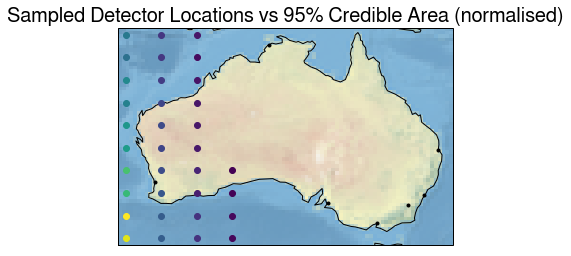

In [36]:
#---- Create plots from data file ---


#------ Create and Setup Output file -----
try:
    fp = open('./OZHF_locations_with_H1_L1_V1_outdir/credible_levels.txt',mode='r')
except IOError:
    print('Error opening file, exiting ...')
    sys.exit

#------ read from file -------
lats = []
longs = []
bayes_factors = []
RA_cred = []
Dec_cred = []
Posterior_Volume = []
bayes_evidence=[]
cred_area=[]


for i,line in enumerate(fp) :
    line = " ".join(line.split())
    line = line.split(" ")
    if i == 0:
        continue
    lats.append(line[0])
    longs.append(line[1])
    RA_cred.append(line[2])
    Dec_cred.append(line[3])
    bayes_factors.append(line[4])
    bayes_evidence.append(line[5])
    Posterior_Volume.append(line[6])
    cred_area.append(line[7])


#-------- Convert to floats and normalise --------
mean_cred = [(float(i)+float(j))/2 for i in RA_cred for j in Dec_cred]

bayes_factors=[float(i) for i in bayes_factors]
bayes_factors=normalise_vector(bayes_factors)

bayes_evidence=[float(i) for i in bayes_evidence]
bayes_evidence=normalise_vector(bayes_evidence)

Posterior_Volume=[float(i) for i in Posterior_Volume]
Posterior_Volume=normalise_vector(Posterior_Volume)

cred_area=[float(i) for i in cred_area]
#cred_area=normalise_vector(cred_area)

mean_cred=normalise_vector(mean_cred)

lats=[float(i) for i in lats]
longs=[float(i) for i in longs]


#----------------

        
#---------------


#---- Plot the sampled locations over map of Aus ----

bayes_fig = plt.figure(1)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(bayes_factors[i]),marker='o',linestyle="")

plt.title("Sampled Detector Locations vs Log Bayes Factor (normalised)")

plt.close()

credible_fig = plt.figure(2)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(mean_cred[i]),marker='o',linestyle="")
plt.title("Sampled Detector Locations vs Mean Injection Credible Level \n(RA & Dec) (normalised)")

if (hide_plots == True) :
    plt.close()

pvolume_fig = plt.figure(3)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(Posterior_Volume[i]),marker='o',linestyle="")
plt.title("Sampled Detector Locations vs Posterior Volume (normalised)")

if (hide_plots == True) :
    plt.close()

evidence_fig = plt.figure(4)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(bayes_evidence[i]),marker='o',linestyle="")
plt.title("Sampled Detector Locations vs Log Evidence (normalised)")

if (hide_plots == True) :
    plt.close()

cred_area_fig = plt.figure(5)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
plot_cities()
plt.xlim(longitude_limits[0]-1,longitude_limits[1]+1)
plt.ylim(latitude_limits[0]-1,latitude_limits[1]+1)
for i in range(len(lats)) :
    plt.plot(longs[i],lats[i],color=plt.cm.viridis(normalise_vector(cred_area)[i]),marker='o',linestyle="")
plt.title("Sampled Detector Locations vs 95% Credible Area (normalised)")

plt.show()





!!! Error !!! ... the input vector is not of even length


SystemExit: 

/home/mitchell/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


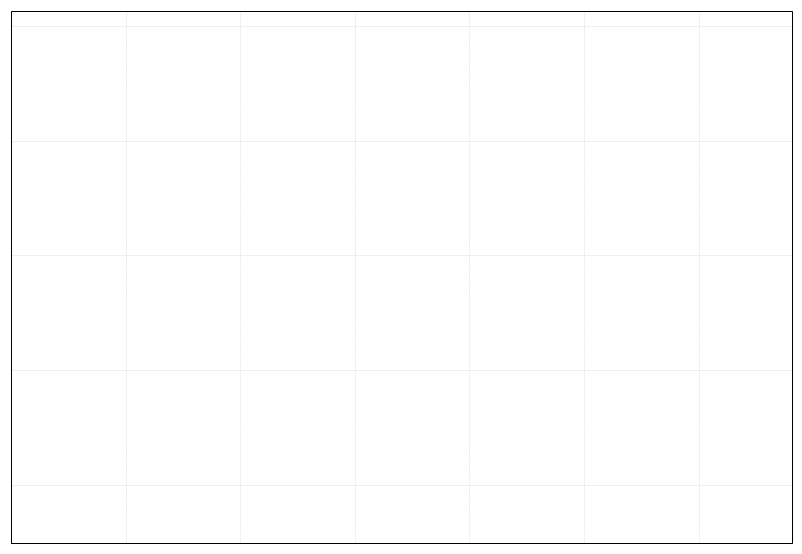

In [37]:
#Plot contour plots over Australia
cred_area_cont_fig = plt.figure(6,figsize=(14,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(color='white')
ax.gridlines()
plot_cities(color='white')
plt.contourf(mesh_long,mesh_lat,convert_to_coord_matrix(cred_area))
plt.colorbar()
plt.title("Sampled Detector Locations \nvs 95% Credible Area")
plt.show()